## Подготовка данных

### Загрузка данных

In [1]:
!pip install feather-format

In [2]:
!pip install pyarrow

In [3]:
!pip install phik

In [4]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
#    recall_score,
    f1_score, 
#    roc_auc_score,
#    roc_curve,
    ConfusionMatrixDisplay
)

RANDOM_STATE=12345

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 300)

sns.set_style("darkgrid")

In [5]:
pd.set_option('display.max_rows', None)

In [6]:
pd.reset_option('display.max_rows')

In [7]:
path = 'C:/Users/Natal/Downloads/datasets'

orders = pd.read_feather(f'{path}/orders.feather')
teacher_prices = pd.read_feather(f'{path}/teacher_prices.feather')
teachers = pd.read_feather(f'{path}/teachers.feather')
teachers_info = pd.read_feather(f'{path}/teachers_info.feather')
lesson_course = pd.read_feather(f'{path}/lesson_course.feather')
lessons = pd.read_feather(f'{path}/lessons.feather')

In [8]:
def get_data_info(data):
    print('\nПервые 5 строк датафрейма:')
    display(data.head())
    print('\nОсновная информация о датафрейме с помощью метода info():\n')
    print(data.info())
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    display(
        pd.DataFrame(data=zip(data.columns, data.isna().sum(), data.isna().mean()*100), \
        columns = ['названия столбцов','кол-во пропусков', 'пропуски в %'])
            .sort_values(by='кол-во пропусков', ascending=False).style.background_gradient('cool'))
    print('\nОписательная статистика с помощью метода describe():\n')    
    display(data.describe(include='all').round(2).T)
#    print('\nРаспределение численных признаков:\n')    
#    data.hist(figsize=(20,25), color='#32B5C9', edgecolor='cyan', xrot=45)
    plt.show()
          

#### orders

##### Обзор данных

In [9]:
get_data_info(orders)


Первые 5 строк датафрейма:


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к заявке № 2294000"" (Алешина Марина)",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.,800,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занятий в неделю: 1, будни и суббота после 17, воскресенье в течение дня.",2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.,700,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, вторник, четверг с 17, суббота с 14.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 20 лет до 90 лет.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель.",2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-nul

,названия столбцов,кол-во пропусков,пропуски в %
13,prefered_teacher_id,1191857,99.999664
6,lesson_place,1191830,99.997399
34,max_metro_distance,1178343,98.865807
36,payment_date,1062196,89.120795
16,first_lesson_date,1025290,86.024293
12,comments,850393,71.350015
17,creator_id,612163,51.361946
31,original_order_id,609273,51.119468
7,home_metro_id,549414,46.097154
9,start_date,486283,40.800311



Описательная статистика с помощью метода describe():



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1191861.0,NaN,NaN,NaN,2340488.45,344556.25,1742636.0,2041441.0,2341556.0,2638720.0,3605505.0
order_date,1191861,1190749,2021-09-16 03:58:15.883,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subject_id,1181529.0,NaN,NaN,NaN,21.37,6157.32,1.0,3.0,8.0,13.0,3605505.0
purpose,1025351,294447,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.,11450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lesson_price,1191861.0,NaN,NaN,NaN,2019.47,916334.05,0.0,500.0,1000.0,1500.0,1000000000.0
lesson_duration,1191861.0,NaN,NaN,NaN,71.87,6130.49,0.0,60.0,60.0,60.0,3605505.0
lesson_place,31,4,у ученика,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_metro_id,642447.0,NaN,NaN,NaN,813.01,8362.94,1.0,228.0,644.0,1146.0,3605505.0
add_info,1044688,609437,Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.\n,7234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,705578,705033,2023-01-07 20:00:43.073,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете orders содержатся 1191861 строк, 38 столбцов. 6 столбцов содержат более 70% пропусков. Присутствуют явные дубликаты - 900 примеров. Столбцы, содержащие информацию о датах, а также amount_to_pay и estimated_fee имеют некорректный тип данных object. В 22 столбцах  максимальное значение составляет 3605505 - явная аномалия.

Рассмотрим детальнее примеры столбцов, где была выявлена аномалия

In [10]:
orders['subject_id'].unique()

array([1.000000e+00, 2.100000e+01, 8.000000e+00, 3.000000e+00,
       9.000000e+00, 3.300000e+01, 5.000000e+00, 2.000000e+00,
       1.800000e+01, 2.700000e+01, 1.000000e+01, 1.500000e+01,
       1.100000e+01, 6.000000e+00, 1.300000e+01, 1.400000e+01,
       1.200000e+01, 3.600000e+01, 1.900000e+01, 1.700000e+01,
       7.000000e+00,          nan, 2.000000e+01, 2.500000e+01,
       4.000000e+00, 2.900000e+01, 2.300000e+01, 1.600000e+01,
       3.211265e+06, 3.342337e+06, 3.605505e+06], dtype=float32)

In [11]:
orders['prefered_teacher_id'].unique()

array([     nan, 3211265., 3342337., 3605505.], dtype=float32)

Как видно, в данных встречаются 3 повторяющихся аномальных значения. Посмотрим строки, содержащие их.

In [12]:
orders.query('prefered_teacher_id in [3211265., 3342337., 3605505.]')

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
105390,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,0042-01-12 05:09:05.007,3211265.0,3211265,None,3211265.0,"8,344264636103745E-308",3211265,0042-01-12 05:09:05.007,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",0042-01-12 05:09:05.007,1
109392,3342337,0042-01-12 04:26:08.039,3342337.0,None,3342337,3342337,None,3342337.0,None,0042-01-12 04:26:08.039,3342337.0,3342337,None,3342337.0,"8,344239172283769E-308",3342337,0042-01-12 04:26:08.039,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,3342337.0,3342337.0,"8,344239172283769E-308",0042-01-12 04:26:08.039,1
79972,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,0042-01-12 05:09:05.007,3211265.0,3211265,None,3211265.0,"8,344264636103745E-308",3211265,0042-01-12 05:09:05.007,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",0042-01-12 05:09:05.007,1
437216,3605505,0029-07-18 05:28:02.684,3605505.0,None,3605505,3605505,None,3605505.0,None,0029-07-18 05:28:02.684,3605505.0,3605505,None,3605505.0,"4,450342944189884E-308",3605505,0029-07-18 05:28:02.684,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,3605505.0,3605505.0,"4,450342944189884E-308",0029-07-18 05:28:02.684,1


In [13]:
# Проверка на уникальность индексов

orders.index.is_unique

False

In [14]:
orders.index.duplicated(keep=False).sum()

1103315

Мы имеем более миллиона задублированных индексов. Сбросим индексы и удалим из датасета строки с аномальными значениями.

In [15]:
orders.reset_index(drop=True, inplace=True)

In [16]:
orders.drop(orders.query('prefered_teacher_id in [3211265., 3342337., 3605505.]').index, inplace=True, axis=0)

После удаления выявленных аномалий гистограммы с распределением численных признаков будут более информативны 

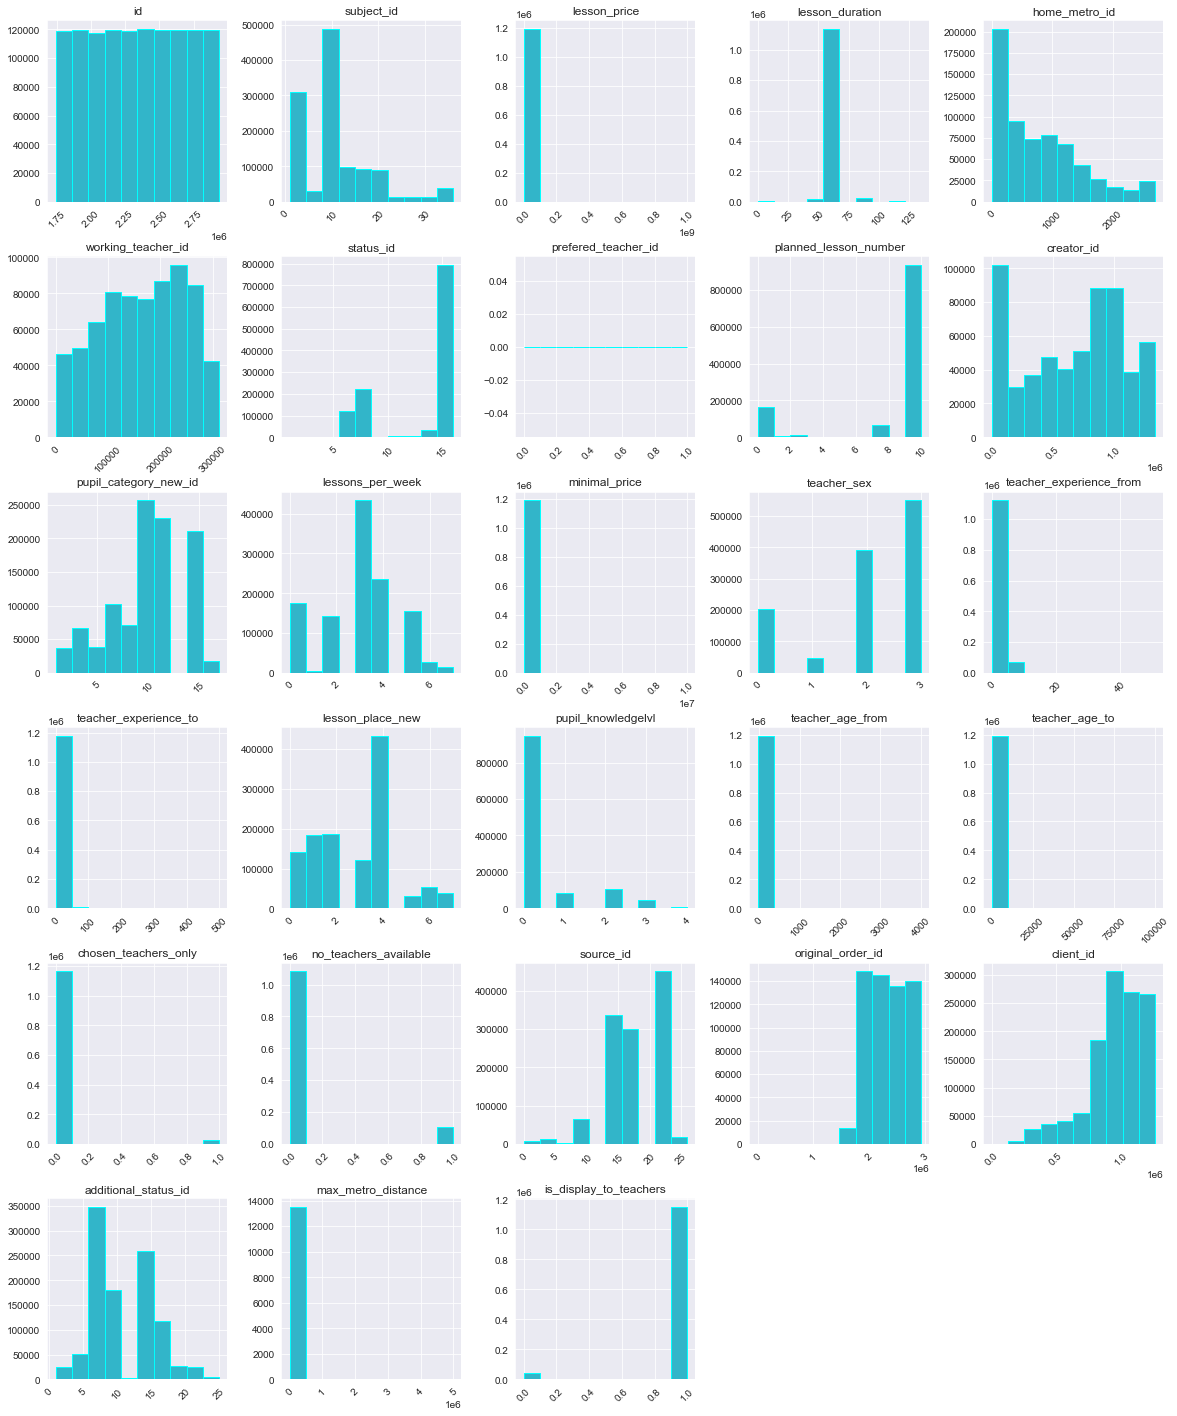

In [17]:
orders.hist(figsize=(20,25), color='#32B5C9', edgecolor='cyan', xrot=45);

Как показывают графики, в признаках lesson_price, minimal_price, max_metro_distance, teacher_experience_to, teacher_age_from, teacher_age_to заметно выбиваются аномальные значения. 

##### Преобразование типов данных

In [18]:
# Переводим в формат даты столбцы order_date, start_date, first_lesson_date, payment_date

orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%dT%H:%M:%S.%f')
orders['start_date'] = pd.to_datetime(orders['start_date'], format='%Y-%m-%dT%H:%M:%S.%f')
orders['first_lesson_date'] = pd.to_datetime(orders['first_lesson_date'], format='%Y-%m-%dT%H:%M:%S.%f')
orders['payment_date'] = pd.to_datetime(orders['payment_date'], format='%Y-%m-%dT%H:%M:%S.%f')

In [19]:
# Преобразуем в вещественные значения тип данных в столбце amount_to_pay
# c помощью метода astype(), параметра errors='raise' и Exception для определения ошибок

try:
    orders['amount_to_pay'] = orders['amount_to_pay'].astype('float', errors='raise')    
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")

Unexpected err=ValueError("could not convert string to float: '1762,5'"), type(err)=<class 'ValueError'>


В столбце присутствуют значения, где дробная часть отделена запятой вместо точки. Произведём замену и затем преобразуем тип данных.

In [20]:
orders['amount_to_pay'].replace(',','.', regex=True, inplace = True)

In [21]:
orders['amount_to_pay'] = orders['amount_to_pay'].astype(float) 

In [22]:
# Преобразуем в вещественные значения тип данных в столбце estimated_fee
# c помощью метода astype(), параметра errors='raise' и Exception для определения ошибок

try:
    orders['estimated_fee'] = orders['estimated_fee'].astype('float', errors='raise')    
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")

Unexpected err=ValueError("could not convert string to float: '2768,3'"), type(err)=<class 'ValueError'>


In [23]:
orders['estimated_fee'].replace(',','.', regex=True, inplace = True)

In [24]:
orders['estimated_fee'] = orders['estimated_fee'].astype(float) 

In [25]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191857 entries, 0 to 1191859
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1191857 non-null  int32         
 1   order_date               1191857 non-null  datetime64[ns]
 2   subject_id               1181525 non-null  float32       
 3   purpose                  1025351 non-null  object        
 4   lesson_price             1191857 non-null  int32         
 5   lesson_duration          1191857 non-null  int32         
 6   lesson_place             31 non-null       object        
 7   home_metro_id            642443 non-null   float32       
 8   add_info                 1044688 non-null  object        
 9   start_date               705574 non-null   datetime64[ns]
 10  working_teacher_id       705984 non-null   float32       
 11  status_id                1191857 non-null  int32         
 12  

##### Удаление явных дубликатов

In [26]:
orders.drop_duplicates(keep='first', inplace=True)

In [27]:
orders.duplicated().sum()

0

##### Анализ аномалий

  0%|                                                                                      | 0/1190958 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lesson_price,1190958.0,2008.94,916660.88,0.0,0.0,500.0,1000.0,1500.0,2500.0,1.000000e+09


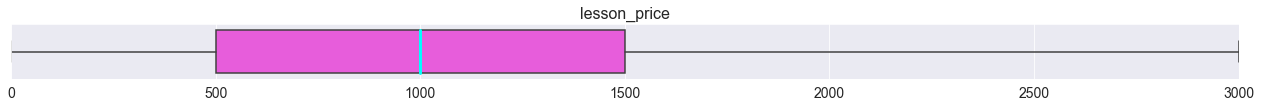

  0%|                                                                           | 1/1190958 [00:00<81:24:58,  4.06it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
minimal_price,1190958.0,201.84,9270.9,0.0,0.0,0.0,0.0,0.0,1000.0,10000000.0


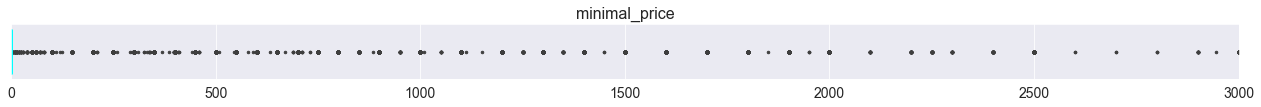

  0%|                                                                          | 2/1190958 [00:00<128:57:19,  2.57it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
max_metro_distance,13501.0,399.76,43030.57,0.0,10.0,30.0,30.0,30.0,40.0,5000000.0


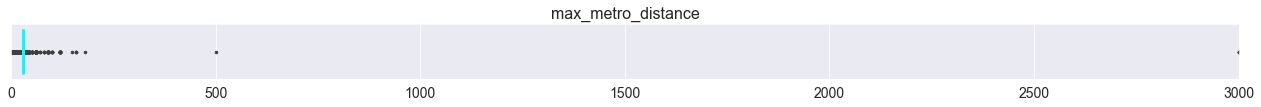

  0%|                                                                          | 3/1190958 [00:00<100:15:52,  3.30it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
teacher_experience_to,1190958.0,0.89,8.38,0.0,0.0,0.0,0.0,0.0,0.0,500.0


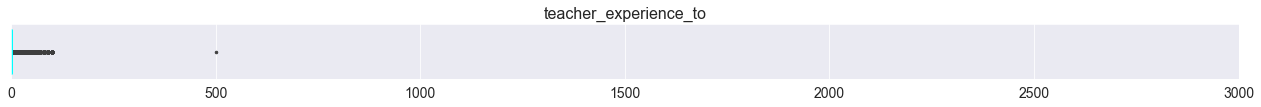

  0%|                                                                           | 4/1190958 [00:01<86:45:13,  3.81it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
teacher_age_from,1190958.0,8.33,13.4,-40.0,0.0,0.0,0.0,20.0,30.0,4016.0


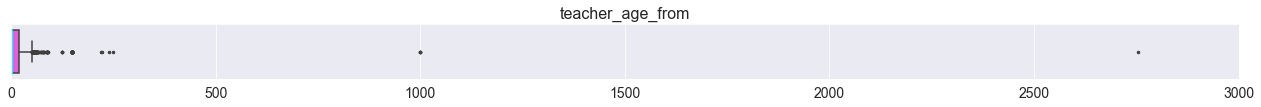

  0%|                                                                           | 5/1190958 [00:01<84:09:28,  3.93it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
teacher_age_to,1190958.0,17.41,100.11,-110.0,0.0,0.0,0.0,40.0,80.0,99999.0


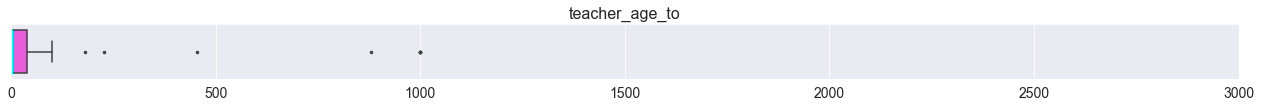

  0%|                                                                           | 6/1190958 [00:01<89:42:23,  3.69it/s]


In [28]:
orders_features = ['lesson_price', 'minimal_price', 'max_metro_distance', 'teacher_experience_to', 'teacher_age_from', 'teacher_age_to']
for i in tqdm(orders[orders_features]):
    display(pd.DataFrame(orders[i]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=orders[i],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(i, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.xlim(0,3000)
    plt.show()

В рассмотренных признаках присутствуют аномалии, однако они лишь говорят о неаккуратном заполнении заявок заказчиками/менеджерами и тем более никак не характеризуют репетиторов, поэтому нет смысла в их обработке. 

In [29]:
for i in orders.columns:
    if orders[i].nunique() > 30:
        print(f'Кол-во уникальных значений в столбце {i}: {orders[i].nunique()}')
    else:
        print(f'\nУникальные значений в столбце {i}:\n{orders[i].value_counts(dropna=False)}\n'+ '-'*50)

Кол-во уникальных значений в столбце id: 1190958
Кол-во уникальных значений в столбце order_date: 1190746

Уникальные значений в столбце subject_id:
8.0     311066
2.0     170675
1.0     109052
18.0     64282
11.0     59734
9.0      58706
10.0     57223
19.0     46684
12.0     42127
14.0     36796
33.0     33318
21.0     24767
13.0     20048
3.0      17515
20.0     16651
7.0      16147
29.0     12622
4.0      12595
27.0     12281
15.0     11367
NaN      10325
6.0       8682
16.0      8171
17.0      7853
23.0      7281
36.0      5625
25.0      4909
5.0       4456
Name: subject_id, dtype: int64
--------------------------------------------------
Кол-во уникальных значений в столбце purpose: 294447
Кол-во уникальных значений в столбце lesson_price: 346

Уникальные значений в столбце lesson_duration:
60     1135634
90       25634
45       19902
120       7210
0         2386
135        192
Name: lesson_duration, dtype: int64
--------------------------------------------------

Уникальные знач

In [30]:
orders.query('subject_id in [8, 2, 1]')

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,NaT,NaN,16,None,NaN,0.0,0,NaT,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,NaN,NaT,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,NaT,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к заявке № 2294000"" (Алешина Марина)",NaN,0.0,0,NaT,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,NaN,NaT,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.,700,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, вторник, четверг с 17, суббота с 14.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 20 лет до 90 лет.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель.",2022-11-01 00:08:47.437,236392.0,16,None,NaN,0.0,10,NaT,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310.0,NaT,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,NaT,NaN,16,Тестовая группа : SplitTestA,NaN,0.0,0,NaT,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,NaN,NaT,1
18,2294072,2022-11-01 00:45:46.343,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 8 класса.\nЦель занятий: улучшить успеваемость.,1500,60,None,127.0,Район: м. Перово.\nМесто проведения занятий: у ученика (ул Кусковская ).\nПредполагаемое число занятий в неделю: 1 Воскресенье - в любое время.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподават...,2022-11-02 09:10:13.487,103581.0,16,None,NaN,0.0,10,NaT,NaN,9.0,2,0,3,0,0,1,0,0,0,0,0,23,NaN,1024444,10.0,NaN,2925.0,NaT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191852,2280499,2022-10-24 19:43:29.907,1.0,None,0,60,None,NaN,None,NaT,NaN,7,"Тестовая группа : SplitTestA\n24.10.2022 20:24 - ""Заявка прикреплена к заявке № 2280388"" (Качкина Светлана)",NaN,0.0,0,NaT,1055336.0,NaN,0,0,0,0,0,0,0,0,0,0,0,16,2280388.0,1019587,7.0,NaN,NaN,NaT,1
1191853,2280500,2022-10-24 19:44:06.077,8.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса. Оценка 5.\nЦель занятий: подготовка к ЕГЭ (профиль).,1100,90,None,1034.0,"Район: Московский район.\nМесто проведения занятий: у ученика (улица Бирюзова, 2), у преподавателя (Приокский, Семчино, Конищево районы).\nПредполагаемое число занятий в неделю: 2.понедельник, четверг после 15, суббота после 10.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 27 лет до 65 ле...",NaT,NaN,16,None,NaN,0.0,10,NaT,304610.0,12.0,4,0,2,5,0,3,0,27,65,0,1,14,2243958.0,1006956,8.0,NaN,3135.0,NaT,1
1191854,2280501,2022-10-24 19:44:09.217,8.0,None,0,60,None,NaN,None,NaT,NaN,7,Тестовая группа : SplitTestB,NaN,0.0,0,NaT,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,16,NaN,1019631,14.0,NaN,NaN,NaT,1
1191857,2280504,2022-10-24 19:45:40.713,1.0,Разделы: школьный курс.\nКатегория ученика: школьник 5 класса.\nЦель занятий: помощь по школьной программе.,1000,120,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1. Воскресение любое время.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: от 18 лет до 45 лет.\nПол репетитора: женский.\nСтатус репетитора: не имеет значе

In [31]:
# Всего заявок в статусах 6 или 13 

orders.loc[(orders['additional_status_id'] == 6) | (orders['status_id'] == 6) | \
           (orders['additional_status_id'] == 13) | (orders['status_id'] == 13)
          ]['id'].count()

367241

In [32]:
# Выделяем признаки с датами

list_datetime_orders =  orders.select_dtypes(include='datetime64[ns]').columns.to_list()
list_datetime_orders

['order_date', 'start_date', 'first_lesson_date', 'payment_date']

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

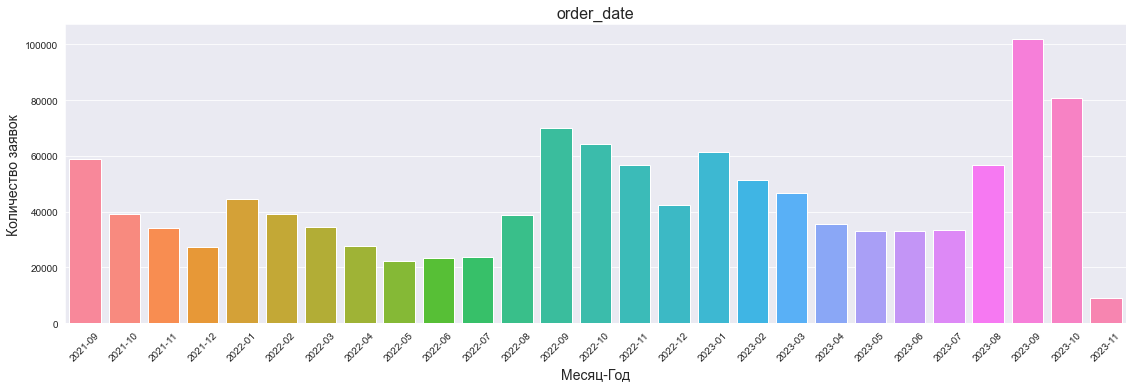

 25%|█████████████████████                                                               | 1/4 [00:07<00:23,  7.90s/it]

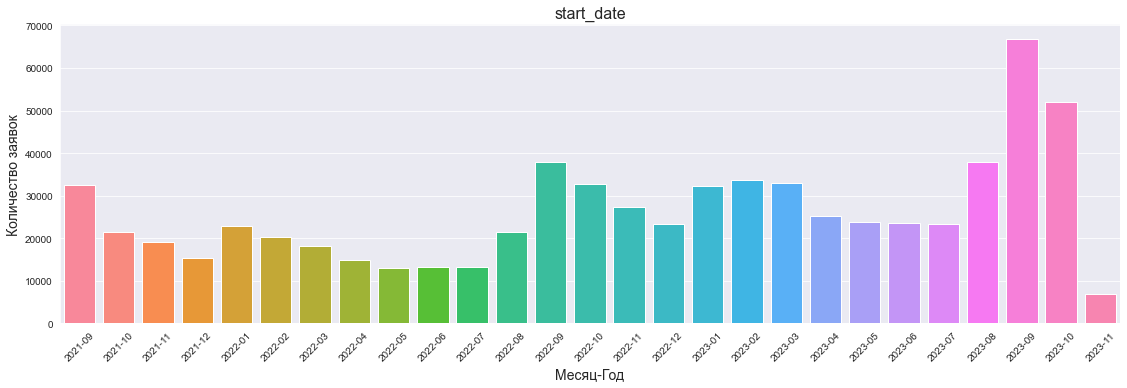

 50%|██████████████████████████████████████████                                          | 2/4 [00:12<00:12,  6.21s/it]

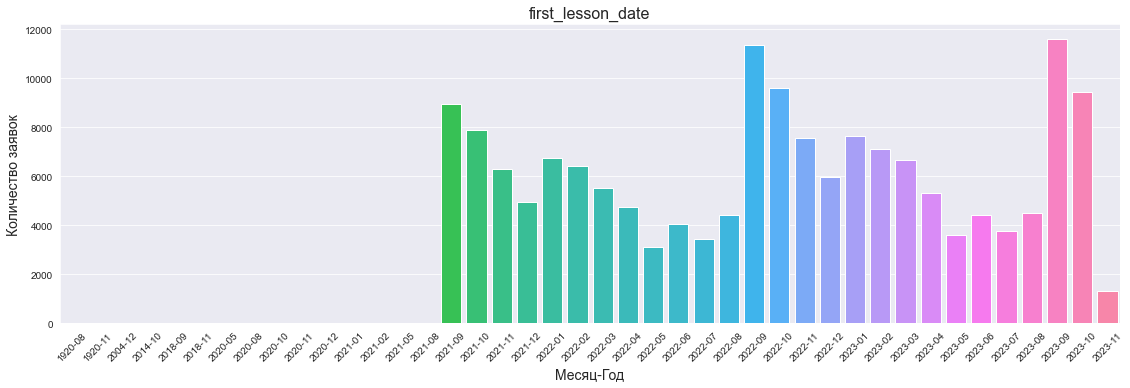

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:14<00:04,  4.14s/it]

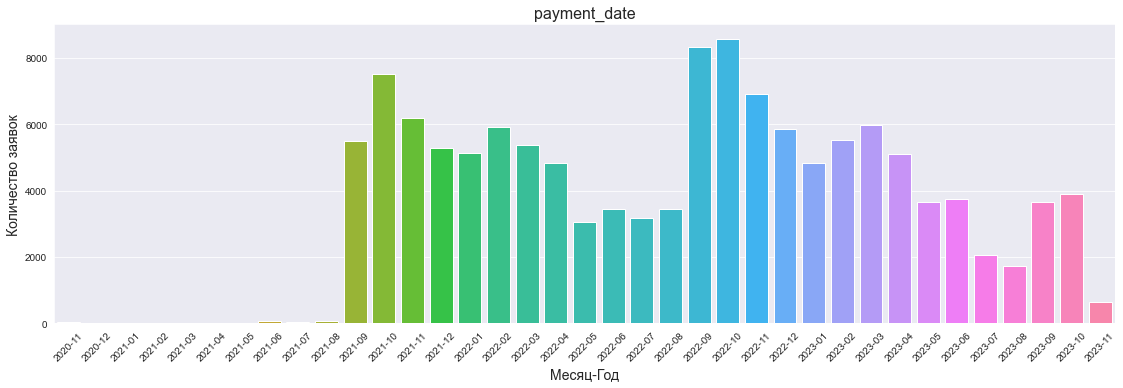

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.04s/it]


In [33]:
# Распределение заявок по месяцам в признаках с датами

for i in tqdm(list_datetime_orders):
    dod = (pd.DataFrame(pd.to_datetime(orders[i]).dt.strftime('%Y-%m')
                      .value_counts()).reset_index().sort_values(by='index'))
    ax = sns.barplot(x='index',
                y=i,
                linewidth=1, 
                saturation = 100,
                data=dod)
    sns.color_palette()
    plt.title(i, fontsize=16)
    plt.xlabel('Месяц-Год', fontsize=14)
    plt.ylabel('Количество заявок', fontsize=14)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    ax.figure.set_size_inches(19,5.5)
    plt.show()

Основную аудиторию пользователей составляют ученики в возрасте от 10 до 15 лет, почти половина всех пользователей берут уроки по 3-м предметам, подавляющее большинство определили свой уровень знаний, как нулевой и выбирают стандартную для занятий с репетитором продолжительность уроков - один час, около 40% предпочитают заниматься с периодичностью 3 раза в неделю. Суммарно ~38% заявок оплачены. Очень близки распределения по кол-ву заявок между признаками даты заявок и старта, а также между датой оплаты и датой первого занятия. В последней паре признаков до октября 2021 наблюдаются аномалии.

#### teacher_prices

##### Обзор данных

In [34]:
get_data_info(teacher_prices)


Первые 5 строк датафрейма:


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB
None

Количество явных дубликатов: 860


,названия столбцов,кол-во пропусков,пропуски в %
1,teacher_id,4570,1.056838
0,date_update,0,0.000000
2,subject_id,0,0.000000
3,price,0,0.000000
4,price_external,0,0.000000
5,price_remote,0,0.000000



Описательная статистика с помощью метода describe():



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_update,432422,380477,2009-04-02 23:46:42.000,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teacher_id,427852.0,NaN,NaN,NaN,145920.68,89895.95,33.0,67969.75,139178.5,220886.25,317929.0
subject_id,432422.0,NaN,NaN,NaN,9.73,8.34,1.0,2.0,8.0,14.0,36.0
price,432422.0,NaN,NaN,NaN,551.94,22974.34,0.0,0.0,400.0,800.0,15045122.0
price_external,432422.0,NaN,NaN,NaN,746.07,28810.35,0.0,0.0,600.0,1000.0,18824823.0
price_remote,432422.0,NaN,NaN,NaN,672.75,23031.29,0.0,0.0,500.0,1000.0,15045122.0


В датасете orders содержатся 432422 строк, 6 столбцов. Столбец с id репетитора, который невозможно восстановить, содержит 1% пропусков. Присутствуют явные дубликаты кол-ве 860 примеров. Столбец дата обновления имеет некорректный тип данных object. В 3-х столбцах с расценками занятий присутствуют аномалим на максимальных значениях.

In [35]:
teacher_prices = teacher_prices[(teacher_prices['price'] < 100000) &  (teacher_prices['price_external'] < 100000) \
               & (teacher_prices['price_remote'] < 100000)]

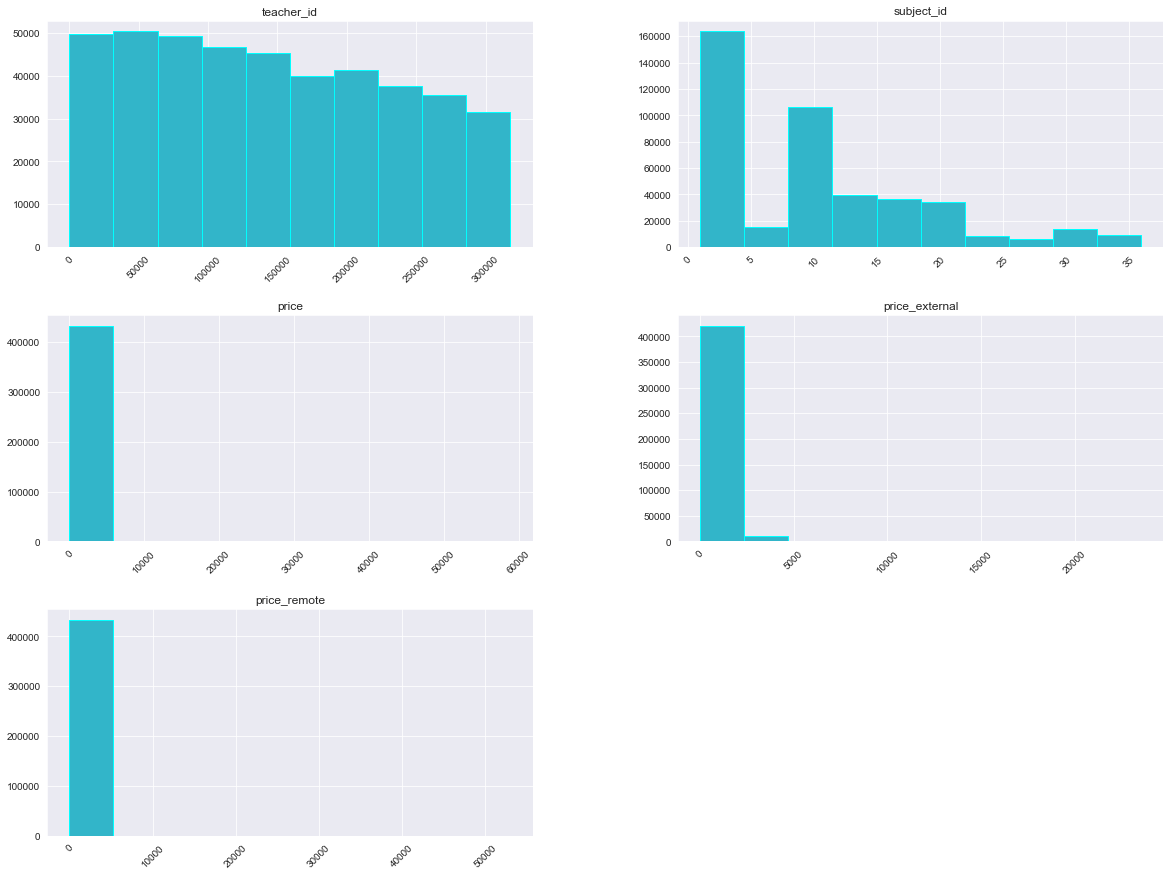

In [36]:
teacher_prices.hist(figsize=(20,15), color='#32B5C9', edgecolor='cyan', xrot=45);

##### Преобразование типов данных

In [37]:
# Переводим в формат даты столбец date_update

teacher_prices['date_update'] = pd.to_datetime(teacher_prices['date_update'], format='%Y-%m-%dT%H:%M:%S.%f')

##### Удаление явных дубликатов

In [38]:
teacher_prices.index.is_unique

True

In [39]:
teacher_prices.duplicated().sum()

860

In [40]:
teacher_prices[teacher_prices.duplicated(keep=False)].sort_values('teacher_id')

,date_update,teacher_id,subject_id,price,price_external,price_remote
184,2008-03-06 23:44:23.847,393.0,21,500,500,500
185,2008-03-06 23:44:23.847,393.0,21,500,500,500
372,2008-04-05 14:00:29.010,733.0,21,1200,1200,1200
373,2008-04-05 14:00:29.010,733.0,21,1200,1200,1200
3718,2008-12-01 01:04:58.223,803.0,21,500,500,500
...,...,...,...,...,...,...
203885,2017-11-29 17:02:58.080,NaN,8,0,500,0
203886,2017-11-29 17:02:58.080,NaN,8,0,500,0
203887,2017-11-29 17:02:58.080,NaN,8,0,500,0
203897,2017-11-29 18:52:32.423,NaN,21,0,1500,0


In [41]:
teacher_prices.drop_duplicates(keep='first', inplace=True)

##### Анализ аномалий

In [42]:
teacher_prices['subject_id'].value_counts()

2     94136
8     61570
1     46793
18    18968
9     18290
19    17730
14    15386
11    14340
13    13620
29    13552
21    12669
10    11991
15    11650
3     11496
4     11020
12    10574
23     6758
6      6604
33     6167
7      5984
27     5950
20     3754
16     2906
5      2858
36     2782
17     2524
25     1483
Name: subject_id, dtype: int64

In [43]:
all_prices_tp = teacher_prices.columns[3:]
all_prices_tp

Index(['price', 'price_external', 'price_remote'], dtype='object')

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,431555.0,512.11,662.41,0.0,0.0,0.0,400.0,800.0,1600.0,58900.0


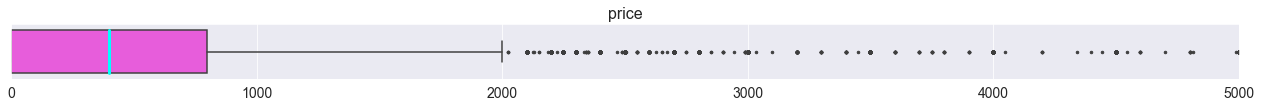

 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  4.85it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
price_external,431555.0,693.35,714.55,0.0,0.0,0.0,600.0,1000.0,2000.0,23560.0


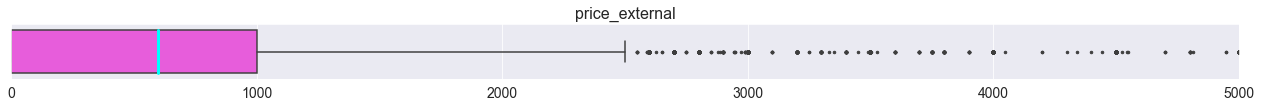

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  4.80it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
price_remote,431555.0,630.23,648.81,0.0,0.0,0.0,500.0,1000.0,1800.0,53010.0


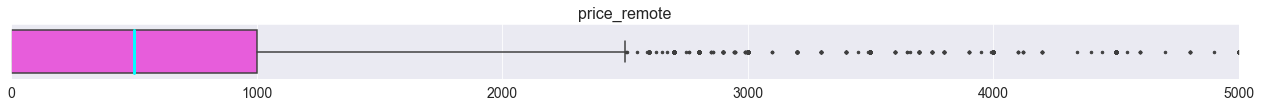

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


In [44]:
for price_tp in tqdm(all_prices_tp):
    display(pd.DataFrame(teacher_prices[price_tp]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=teacher_prices[price_tp],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(price_tp, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.xlim(0,5000)
    plt.show()

Как мы видим, лидирует та же тройка предметов, что и по данным orders, однако первые 2 позиции поменялись местами. По признакам стоимости занятий наблюдаются аномалии от 2-2.5к.

#### teachers

##### Обзор данных

In [45]:
get_data_info(teachers)


Первые 5 строк датафрейма:


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB
None

Количество явных дубликатов: 0


,названия столбцов,кол-во пропусков,пропуски в %
0,id,0,0.000000
1,lessons_delivered,0,0.000000
2,mean_lesson_price,0,0.000000
3,lessons_given,0,0.000000
4,lessons_started_fraction,0,0.000000
5,lessons_per_pupil,0,0.000000
6,money_recieved,0,0.000000
7,blocked,0,0.000000



Описательная статистика с помощью метода describe():



,count,mean,std,min,25%,50%,75%,max
id,1656.0,195700.56,87667.53,458.00,130185.50,210036.50,276014.50,317531.00
lessons_delivered,1656.0,177.65,336.45,1.00,12.00,54.00,207.50,5690.00
mean_lesson_price,1656.0,1509.64,908.72,200.00,994.88,1350.31,1852.01,15000.00
lessons_given,1656.0,104.06,217.64,1.00,8.00,30.00,103.00,3788.00
lessons_started_fraction,1656.0,0.19,0.14,0.01,0.11,0.17,0.25,1.00
lessons_per_pupil,1656.0,9.87,9.60,1.00,3.00,7.09,13.50,78.17
money_recieved,1656.0,175023.75,485008.61,200.00,9000.00,43100.00,148350.00,11162200.00
blocked,1656.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00


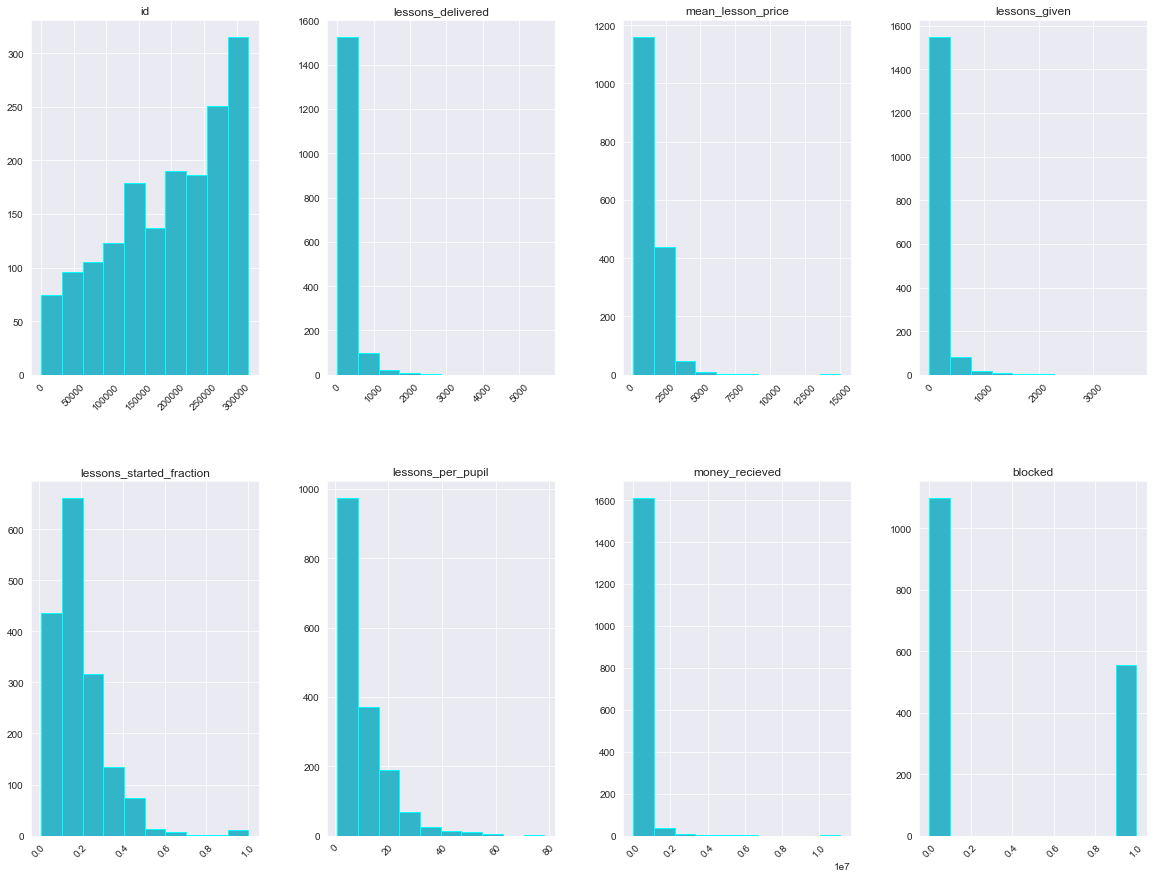

In [46]:
teachers.hist(figsize=(20,15), layout=(2,4), color='#32B5C9', edgecolor='cyan', xrot=45);

В датасете teachers содержится 1656 строк, 8 столбцов. Пропуски и явные дубликаты отсутствуют. В датасете находится целевой признак, который говорит, что заблокированные репетиторы составляют примерно треть от общего числа. В столбце money_recieved максимальное значение составляет более 11 млн. Остальные признаки так же содержат нехарактерные максимальные значения.

##### Анализ аномалий

In [47]:
col_teachers = teachers.columns[1:7]
col_teachers

Index(['lessons_delivered', 'mean_lesson_price', 'lessons_given',
       'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved'],
      dtype='object')

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lessons_delivered,1656.0,177.65,336.45,1.0,2.0,12.0,54.0,207.5,777.0,5690.0


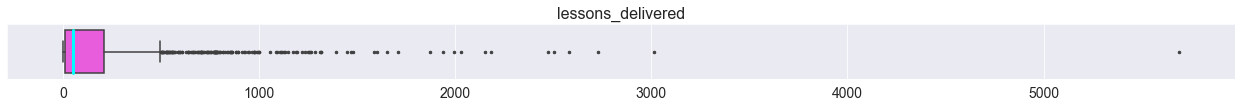

 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.52it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
mean_lesson_price,1656.0,1509.64,908.72,200.0,567.59,994.88,1350.31,1852.01,2915.17,15000.0


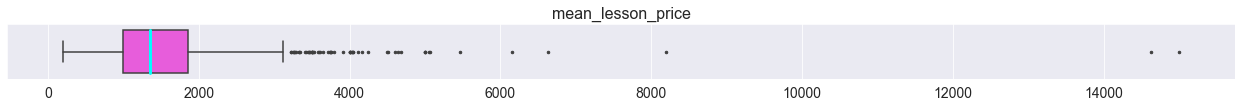

 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  3.47it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lessons_given,1656.0,104.06,217.64,1.0,1.0,8.0,30.0,103.0,469.0,3788.0


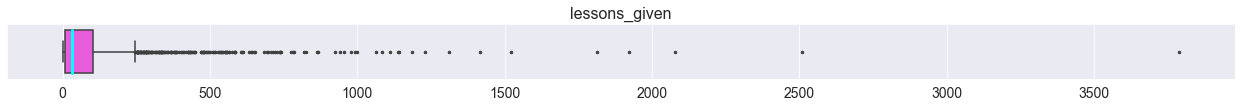

 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  4.20it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lessons_started_fraction,1656.0,0.19,0.14,0.01,0.05,0.11,0.17,0.25,0.45,1.0


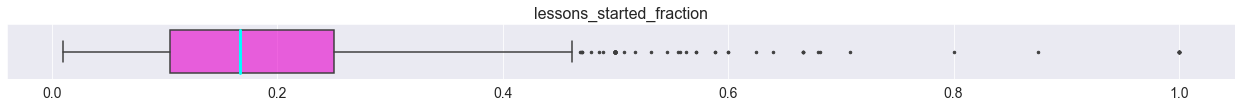

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  4.64it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lessons_per_pupil,1656.0,9.87,9.6,1.0,1.0,3.0,7.09,13.5,27.5,78.17


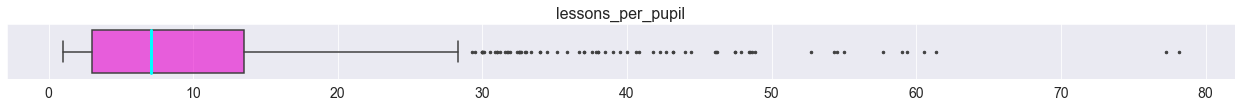

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  4.96it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
money_recieved,1656.0,175023.75,485008.61,200.0,1300.0,9000.0,43100.0,148350.0,714360.75,11162200.0


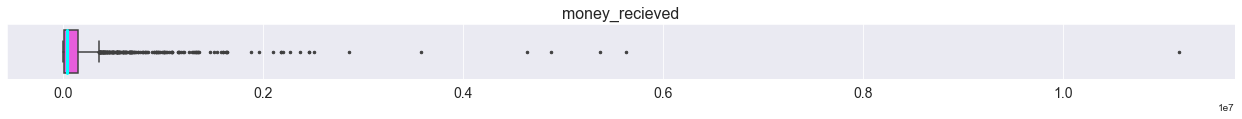

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]


In [48]:
for col in tqdm(col_teachers):
    display(pd.DataFrame(teachers[col]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=teachers[col],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(col, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.show()

В целом, по признакам поставлено и проведено уроков распределения похожи, но, что логично, запланировано в среднем на 40% больше. По признаку средняя стоимость урока статистики среднего и медианы недалеки (1350 и 1500), однако присутствуют аномальные значения, достигающие 15к, из-за чего стандартное отклонение составляет 0.9к. Признак процент начала занятий так же имеет близкие значение медианы и среднего, однако, из-за присутствия высоких аномальных значений имеет перекос вправо. По признаку кол-во занятий на ученика можно заметить, что половина репетиторов проводят до семи занятий с учеником, но есть и чемпионы со средним показателем 78 уроков. Признак получено денег имеет положительную ассиметрию с длинным хвостом, среднее в 4,5 раза превышают медиану равную 43.1к, а четверть репетиторов не принесли и больше 9к.

#### teachers_info

##### Обзор данных

In [49]:
get_data_info(teachers_info)


Первые 5 строк датафрейма:


,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13 

,названия столбцов,кол-во пропусков,пропуски в %
9,is_pupils_needed,296764,96.360708
8,last_visited,72135,23.422584
0,id,0,0.000000
1,reg_date,0,0.000000
2,birth_date,0,0.000000
3,teaching_start_date,0,0.000000
4,is_email_confirmed,0,0.000000
5,lesson_duration,0,0.000000
6,lesson_cost,0,0.000000
7,is_display,0,0.000000



Описательная статистика с помощью метода describe():



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,307972.0,NaN,NaN,NaN,157246.18,90198.01,33.0,79390.75,157384.5,235434.25,312622.0
reg_date,307972,307729,2007-12-24 19:26:46.000,134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_date,307972,22247,1989-01-01 00:00:00.000,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teaching_start_date,307972,776,2017-09-01 00:00:00.000,19269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_email_confirmed,307972.0,NaN,NaN,NaN,0.01,0.11,0.0,0.0,0.0,0.0,1.0
lesson_duration,307972.0,NaN,NaN,NaN,61.5,15.06,1.0,60.0,60.0,60.0,999.0
lesson_cost,307972.0,NaN,NaN,NaN,532.58,2146.36,0.0,0.0,500.0,900.0,1021709.0
is_display,307972.0,NaN,NaN,NaN,0.66,0.47,0.0,0.0,1.0,1.0,1.0
last_visited,235837,235805,2022-10-24 09:11:23.520,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_pupils_needed,11208.0,NaN,NaN,NaN,0.95,0.22,0.0,1.0,1.0,1.0,1.0


В датасете teachers_info содержится 307972 строк, 15 столбцов. Признак __`открыт для заявок`__ имеет более 96% пропусков и __`последний визит`__ - 26%. Явные дубликаты отсутствуют. 4 столбца, содержащие информацию о датах, имеют некорректный тип данных object. В столбцах __`стоимость урока`__ присутствуют аномально высокие значения.

In [50]:
teachers_info = teachers_info[teachers_info['lesson_cost'] < 100000]

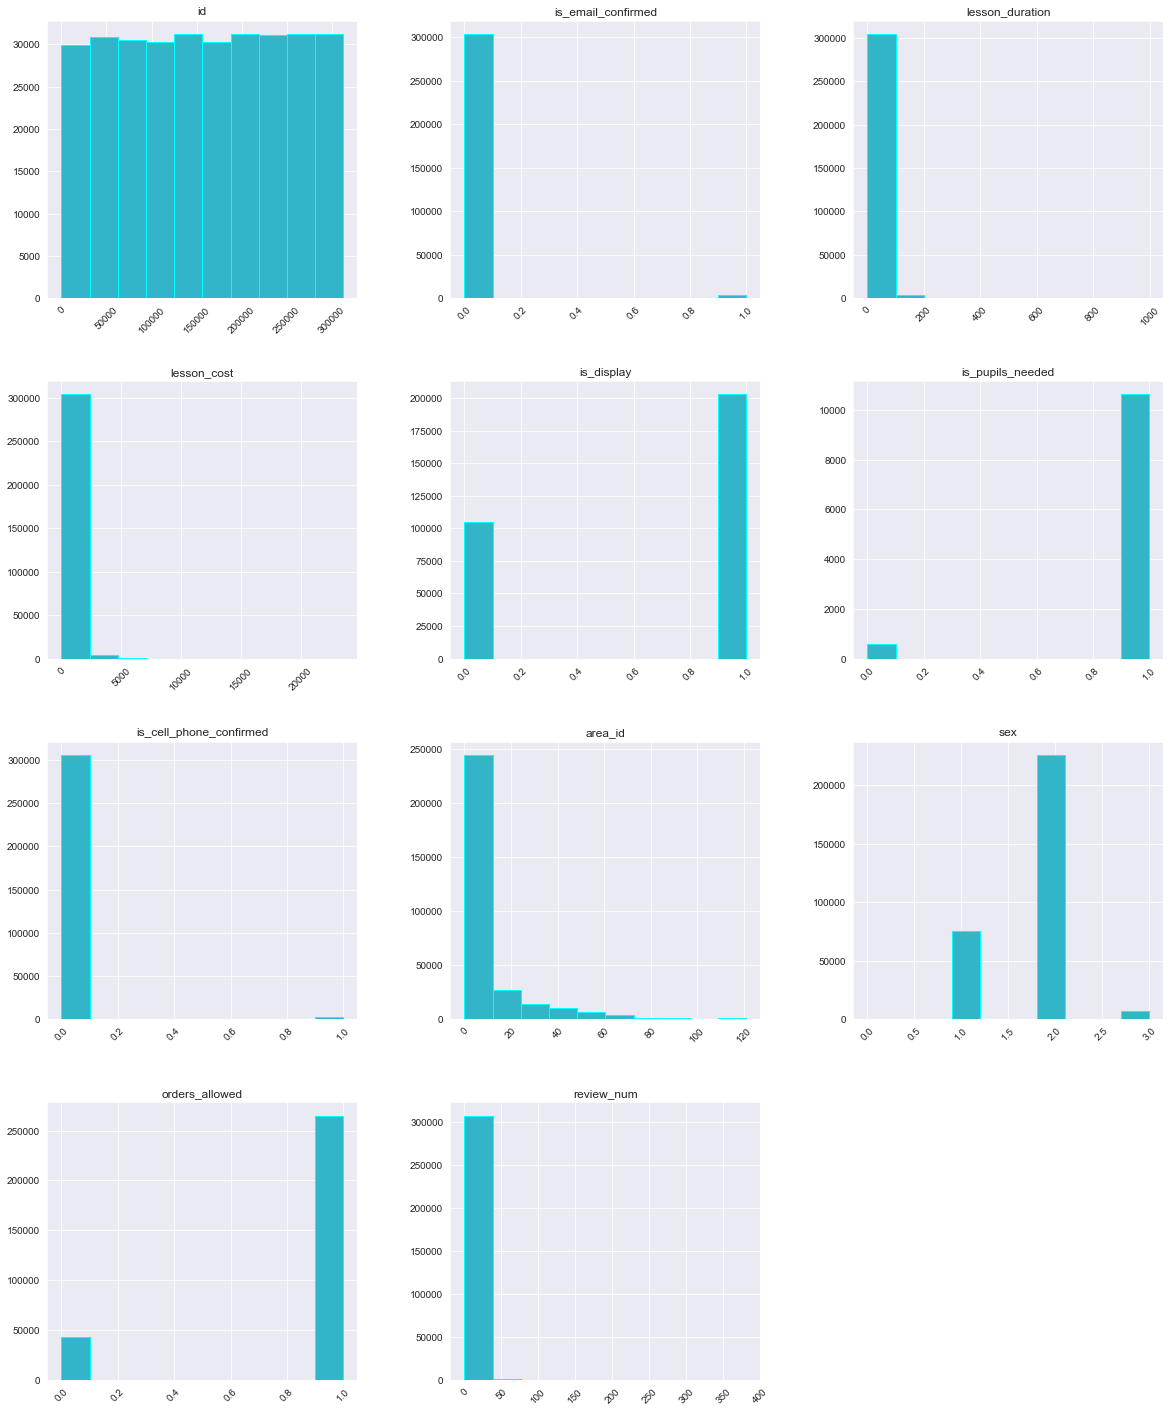

In [51]:
teachers_info.hist(figsize=(20,25), color='#32B5C9', edgecolor='cyan', xrot=45);

Как мы видим из графиков, почти никто из репетиторов не подтвердил свои телефон и мейл при этом подавляющее большинство разрешено назначать и они открыты для заявок, однако, треть не показываются в каталоге. Подавляющее число репетиторов женского пола.  

##### Преобразование типов данных

In [52]:
# Переводим в формат даты столбцы reg_date, birth_date, teaching_start_date, last_visited

teachers_info['reg_date'] = pd.to_datetime(teachers_info['reg_date'], format='%Y-%m-%dT%H:%M:%S.%f')
teachers_info['birth_date'] = pd.to_datetime(teachers_info['birth_date'], format='%Y-%m-%dT%H:%M:%S.%f')
teachers_info['teaching_start_date'] = pd.to_datetime(teachers_info['teaching_start_date'], format='%Y-%m-%dT%H:%M:%S.%f')
teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited'], format='%Y-%m-%dT%H:%M:%S.%f')

##### Анализ аномалий

In [53]:
teachers_info['area_id'].value_counts()

1     173017
2      43221
14      5337
4       4729
6       4546
       ...  
78        25
76        21
89        10
83         6
0          1
Name: area_id, Length: 91, dtype: int64

In [54]:
col_info_teachers = ['lesson_duration', 'lesson_cost', 'review_num']

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lesson_duration,307970.0,61.5,15.06,1.0,45.0,60.0,60.0,60.0,90.0,999.0


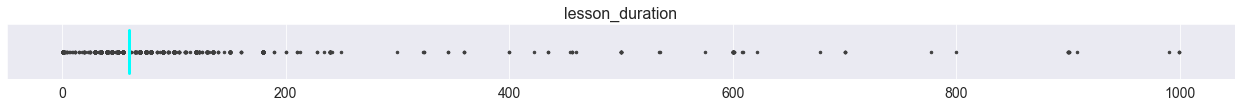

 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  4.01it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lesson_cost,307970.0,527.61,612.46,0.0,0.0,0.0,500.0,900.0,1500.0,23560.0


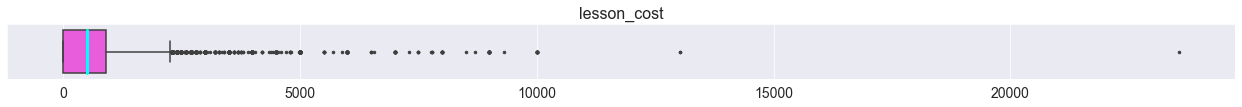

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  5.06it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
review_num,307970.0,1.09,4.86,0.0,0.0,0.0,0.0,0.0,6.0,381.0


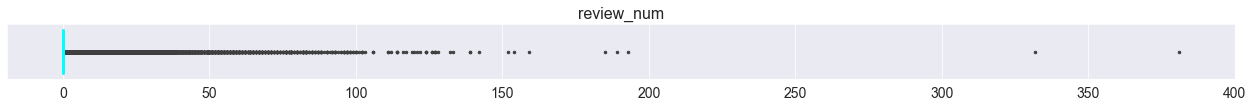

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


In [55]:
for col_info in tqdm(col_info_teachers):
    display(pd.DataFrame(teachers_info[col_info]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=teachers_info[col_info],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(col_info, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.show()

Более половины репетиторов работают предположительно в Москве (регион 1). Менее четверти проводят уроки продолжительностью более часа и у не менее половины цена занятия не превышает 500р, при этом, как минимум у 25% зафиксирована нулевая стоимость. 95% репетиторов имеет не более 6 отзывов, но есть и рекордсмен с показателем 381 отзыв. 

In [56]:
# Выделяем признаки с датами

list_datetime_teachers_info = teachers_info.select_dtypes(include='datetime64[ns]').columns.to_list()
list_datetime_teachers_info

['reg_date', 'birth_date', 'teaching_start_date', 'last_visited']

In [57]:
for i in tqdm(list_datetime_teachers_info):
    display(pd.to_datetime(teachers_info[i]).dt.strftime('%Y-%m').value_counts().reset_index()
     .sort_values(by='index', ascending= False))

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

,index,reg_date
153,2023-11,646
18,2023-10,3336
3,2023-09,4133
2,2023-08,4205
26,2023-07,2805
...,...,...
187,2008-04,155
185,2008-03,180
184,2008-02,198
191,2008-01,102


 25%|█████████████████████                                                               | 1/4 [00:02<00:06,  2.21s/it]

,index,birth_date
824,2017-12,6
247,2017-11,414
196,2017-10,664
163,2017-09,852
204,2017-08,630
...,...,...
944,1860-04,1
972,1858-05,1
937,1843-10,1
916,1833-05,1


 50%|██████████████████████████████████████████                                          | 2/4 [00:04<00:04,  2.13s/it]

,index,teaching_start_date
280,2023-11,11
151,2023-10,64
44,2023-09,983
111,2023-08,136
126,2023-07,110
...,...,...
610,1910-01,1
19,1900-09,3745
578,1900-08,1
579,1900-01,1


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:02,  2.10s/it]

,index,last_visited
0,2022-10,25465
1,2022-09,14863
2,2022-08,9325
4,2022-07,5287
8,2022-06,4354
...,...,...
173,2008-06,28
174,2008-05,24
171,2008-04,35
172,2008-03,35


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]


In [58]:
reg_visit = list_datetime_teachers_info[::len(list_datetime_teachers_info)-1]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

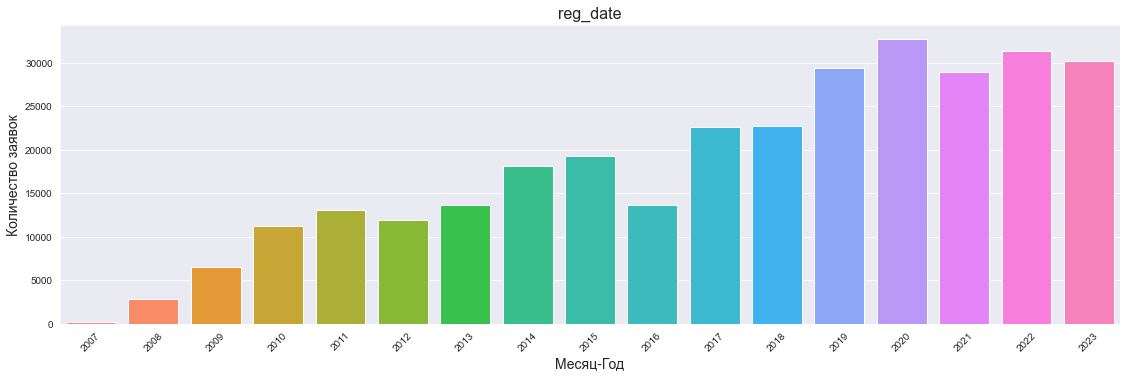

 50%|██████████████████████████████████████████                                          | 1/2 [00:02<00:02,  2.19s/it]

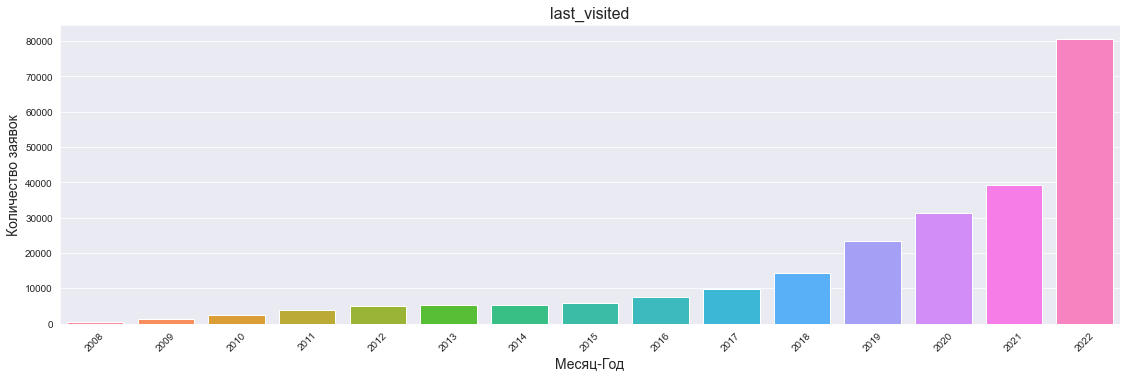

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


In [59]:
# Распределение по датам регистраций и последних визитов в разрезе лет

for i in tqdm(reg_visit):
    odf = (pd.DataFrame(pd.to_datetime(teachers_info[i]).dt.strftime('%Y')
                      .value_counts()).reset_index().sort_values(by='index'))
    ax = sns.barplot(x='index',
                y=i,
                linewidth=1, 
                saturation = 100,
                data=odf)
    sns.color_palette()
    plt.title(i, fontsize=16)
    plt.xlabel('Месяц-Год', fontsize=14)
    plt.ylabel('Количество заявок', fontsize=14)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    ax.figure.set_size_inches(19,5.5)
    plt.show()

Наблюдается стабильный рост по обоим признакам, в 2022г кол-во визитов приросло в 2 раза, однако данные за 2023 год отсутствуют. Данные в признаках дата рождения и дата начала первого занятия вызывают сомнения, как аномально давним датами, так и совсем свежими для даты рождения (2017 г).

#### lesson_course

##### Обзор данных

In [60]:
get_data_info(lesson_course)


Первые 5 строк датафрейма:


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB
None

Количество явных дубликатов: 0


,названия столбцов,кол-во пропусков,пропуски в %
3,order_id,3306,0.370031
1,client_id,1,0.000112
0,id,0,0.000000
2,teacher_id,0,0.000000
4,lesson_place,0,0.000000
5,lesson_price,0,0.000000
6,is_active,0,0.000000
7,lesson_duration,0,0.000000
8,date_updated,0,0.000000
9,suspend_till_date,0,0.000000



Описательная статистика с помощью метода describe():



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,893438.0,NaN,NaN,NaN,1052918.67,259976.6,10.0,830346.25,1053759.5,1277181.75,1505419.0
client_id,893437.0,NaN,NaN,NaN,910499.17,236024.74,1.0,768585.0,926617.0,1107521.0,1268616.0
teacher_id,893438.0,NaN,NaN,NaN,156999.07,79431.72,33.0,95659.0,160006.0,220809.0,312244.0
order_id,890132.0,NaN,NaN,NaN,2201948.91,452451.43,11.0,1808246.5,2219963.5,2602854.25,2936670.0
lesson_place,893438.0,NaN,NaN,NaN,3.4,1.55,0.0,2.0,4.0,4.0,7.0
lesson_price,893438.0,NaN,NaN,NaN,1284.2,3624.32,0.0,700.0,1000.0,1500.0,2500000.0
is_active,893438.0,NaN,NaN,NaN,0.22,0.42,0.0,0.0,0.0,0.0,1.0
lesson_duration,893438.0,NaN,NaN,NaN,-4737.21,3213023.81,-2147483648.0,60.0,60.0,60.0,8032022.0
date_updated,893438,893353,2022-11-08 16:58:14.660,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
suspend_till_date,893438,5606,1800-01-01 00:00:00.000,879146,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете lesson_course содержатся 893438 строк, 10 столбцов. 1 столбец содержит менее 0.5% пропусков. Явные дубликаты отсутсвуют. Столбцы, содержащие информацию о датах, имеют некорректный тип данных object. В 2-х столбцах (стоимость и продолжительность урока) присутствуют, как аномально высокие, так и отрицательные в столбце с длительностью урока значения.

In [61]:
lesson_course = lesson_course.query('0 <= lesson_duration < 2000')

In [62]:
lesson_course = lesson_course.query('lesson_price < 200000')

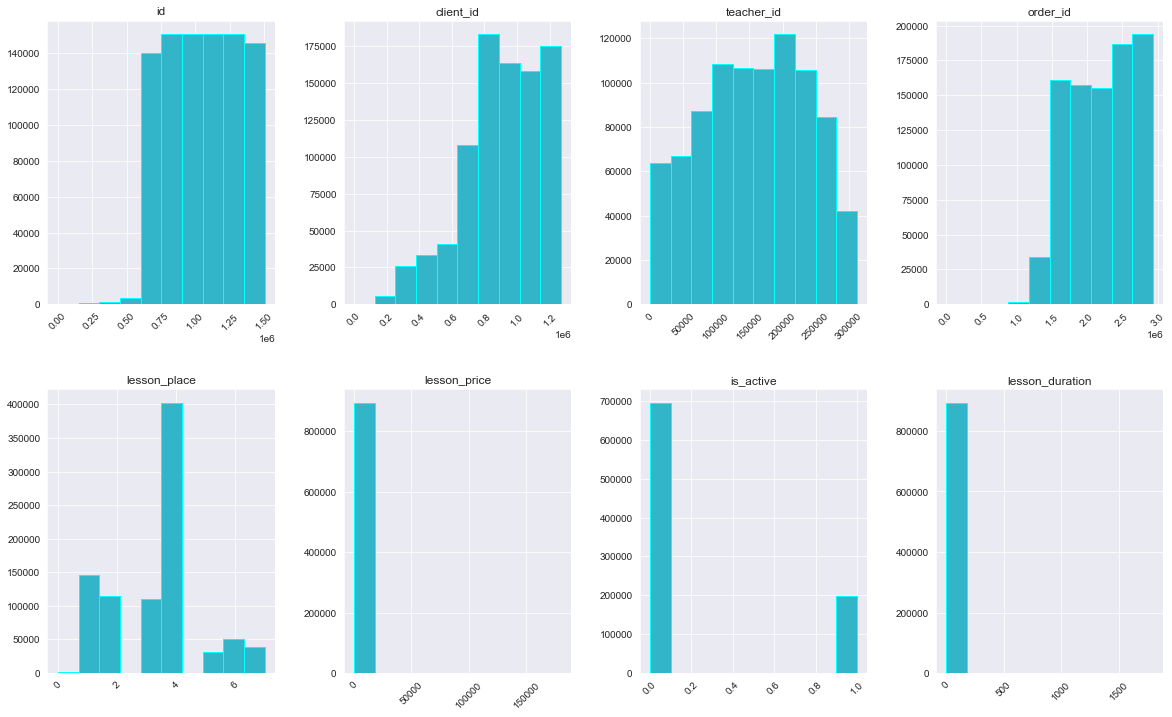

In [63]:
lesson_course.hist(figsize=(20,12), layout=(2,4), color='#32B5C9', edgecolor='cyan', xrot=45);

Как мы можем отметить, 700к из почти 900к серий уроков находятся в активном статусе и 400к проходят удалённо.

##### Преобразование типов данных

In [64]:
# Переводим в формат даты столбцы date_updated, suspend_till_date

lesson_course['date_updated'] = pd.to_datetime(lesson_course['date_updated'], format='%Y-%m-%dT%H:%M:%S.%f')
lesson_course['suspend_till_date'] = pd.to_datetime(lesson_course['suspend_till_date'], format='%Y-%m-%dT%H:%M:%S.%f')

In [65]:
lesson_course.duplicated().sum()

0

In [66]:
lesson_course[lesson_course['lesson_duration']> 1000].count()

id                   32
client_id            32
teacher_id           32
order_id             32
lesson_place         32
lesson_price         32
is_active            32
lesson_duration      32
date_updated         32
suspend_till_date    32
dtype: int64

##### Анализ аномалий

In [67]:
lessons_lp = ['lesson_price', 'lesson_duration']

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lesson_price,893416.0,1275.47,1538.28,0.0,500.0,700.0,1000.0,1500.0,2500.0,180000.0


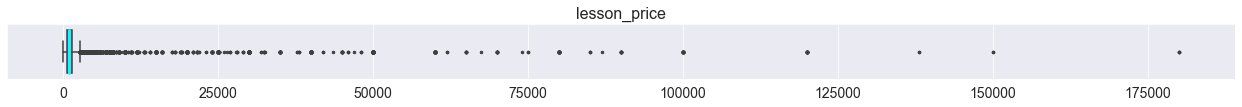

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  3.49it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
lesson_duration,893416.0,60.99,18.78,0.0,60.0,60.0,60.0,60.0,90.0,1800.0


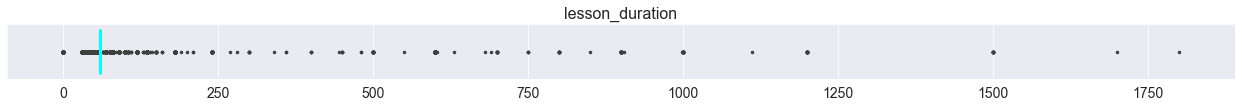

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


In [68]:
for i in tqdm(lessons_lp):
    display(pd.DataFrame(lesson_course[i]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=lesson_course[i],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(i, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.show()

In [69]:
# Выделяем признаки с датами

list_datetime_lc =  lesson_course.select_dtypes(include='datetime64[ns]').columns.to_list()
list_datetime_lc

['date_updated', 'suspend_till_date']

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

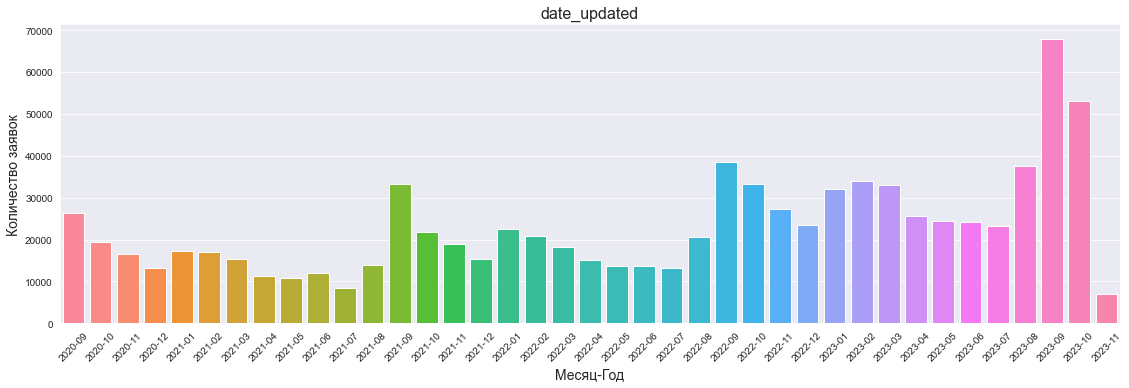

 50%|██████████████████████████████████████████                                          | 1/2 [00:06<00:06,  6.02s/it]

,index,suspend_till_date
0,1800-01,879124
1,2021-09,1135
2,2022-09,999
3,2023-09,929
4,2020-09,830
...,...,...
125,2027-09,1
108,2028-03,1
101,2028-10,1
110,2017-08,1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.92s/it]


In [70]:
# Распределение серий уроков по месяцам в признаках с датами

for i in tqdm(list_datetime_lc):
    ddl = (pd.DataFrame(pd.to_datetime(lesson_course[i]).dt.strftime('%Y-%m')
                      .value_counts()).reset_index().sort_values(by='index'))
    if i == list_datetime_lc[0]:
        ax = sns.barplot(x='index',
                y=i,
                linewidth=1, 
                saturation = 100,
                data=ddl)

#         ax = sns.barplot(x='index',
#                 y=i,
#                 linewidth=1, 
#                 saturation = 100,
#                 data=ddl.loc[ddl['index'] != '1800-01'])        
        sns.color_palette()
        plt.title(i, fontsize=16)
        plt.xlabel('Месяц-Год', fontsize=14)
        plt.ylabel('Количество заявок', fontsize=14)
        plt.xticks(fontsize=10, rotation=45)
        plt.yticks(fontsize=10)
        ax.figure.set_size_inches(19,5.5)
        plt.show()
    else:
        display(ddl.sort_values(by=i, ascending=False))

Как видно из данных, 95% курсов со стоимостью занятий, не превышающей 2.5к, но отдельные курсы доходят до отметки 180к. Не менее 75% имеют продолжительность до 60 минут, а максимальное время - 30 часов. По признаку __`дата обновления`__ можно заметить ежегодные пики в периоды начала учебного года, у признака __`приостановлен до даты`__ также всплески приходятся на сентябрь, но 98% данных заполнены заглушкой.

#### lessons

##### Обзор данных

In [71]:
get_data_info(lessons)


Первые 5 строк датафрейма:


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN



Основная информация о датафрейме с помощью метода info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB
None

Количество явных дубликатов: 0


,названия столбцов,кол-во пропусков,пропуски в %
5,home_task,1186158,99.582832
8,amount_paid,1182984,99.316362
7,amount_to_pay,597751,50.183650
0,id,0,0.000000
1,lesson_course_id,0,0.000000
2,lesson_date,0,0.000000
3,time_from,0,0.000000
4,time_to,0,0.000000
6,is_regular,0,0.000000



Описательная статистика с помощью метода describe():



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1191127.0,NaN,NaN,NaN,2924255.51,786006.67,135797.0,2238783.5,2891741.0,3546279.5,4516941.0
lesson_course_id,1191127.0,NaN,NaN,NaN,992297.37,271157.29,3.0,817758.0,983343.0,1157515.0,1610713.0
lesson_date,1191127,884,2024-01-31 00:00:00.000,2051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_from,1191127,2721,18:00:00,129207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_to,1191127,3071,19:00:00,120137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_task,4969,4310,дано,107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_regular,1191127.0,NaN,NaN,NaN,0.17,0.38,0.0,0.0,0.0,0.0,1.0
amount_to_pay,593376.0,NaN,NaN,NaN,1183.84,4684.53,0.0,700.0,1000.0,1500.0,2500000.0
amount_paid,8143.0,NaN,NaN,NaN,1817.35,972.74,200.0,1100.0,1500.0,2000.0,24000.0


В датасете lessons содержатся 1191127 строк, 9 столбцов. Столбцы __`стоимость`__ и __`домашнее задание`__ имеют более 99% пропусков и более половины приходится на признак __`оплачено`__. Явные дубликаты отсутсвуют. Столбцы, содержащие информацию о датах, имеют некорректный тип данных category. В столбце  __`стоимость`__ максимальное значение составляет 2.5кк - явная аномалия.

In [72]:
lessons = lessons[(lessons['amount_to_pay'] <= 100000) | (lessons['amount_to_pay'].isna())]

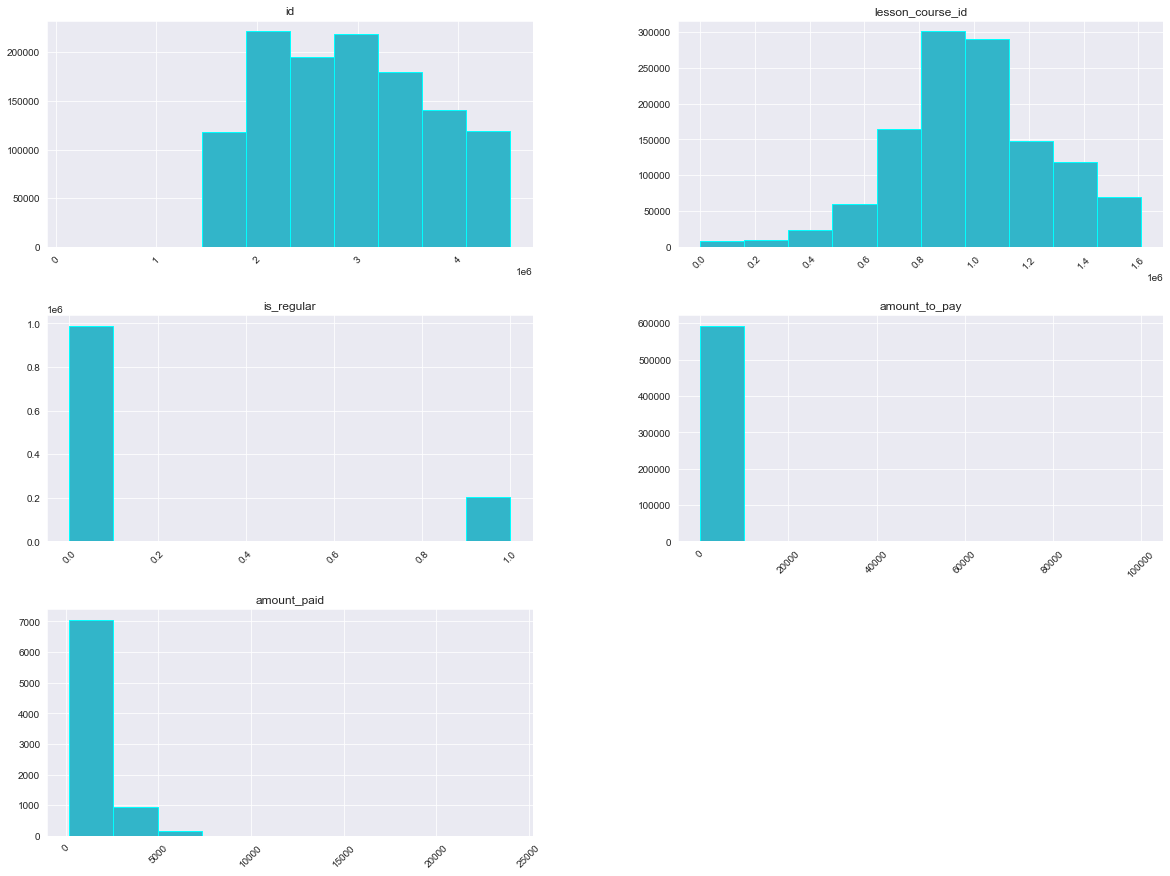

In [73]:
lessons.hist(figsize=(20,15), color='#32B5C9', edgecolor='cyan', xrot=45);

На серии с автоматически повторяющимися занятиями приходится около 200к уроков, что составляет более 16% от их общего числа. Поскольку признак amount_paid имеет более 99% пропусков статистика по нему весьма скудная: 7к наблюдений с оплатой, не превышающей сумму 2.5к, и ещё 1к в диапозоне 2.5-5к.

##### Преобразование типов данных

In [74]:
# Переводим в формат даты столбец lesson_date

lessons['lesson_date'] = pd.to_datetime(lessons['lesson_date'], format='%Y-%m-%dT%H:%M:%S.%f')

In [75]:
# Преобразуем тип данных time_from, time_to

lessons['time_from'] = pd.to_datetime(lessons['time_from'], format='%H:%M:%S', errors='coerce').dt.time
lessons['time_to'] = pd.to_datetime(lessons['time_from'], format='%H:%M:%S', errors='coerce').dt.time

##### Анализ аномалий

In [76]:
amount_pay_lessons = lessons.columns[7:]
amount_pay_lessons

Index(['amount_to_pay', 'amount_paid'], dtype='object')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
amount_to_pay,593369.0,1170.71,934.49,0.0,0.0,700.0,1000.0,1500.0,2500.0,100000.0


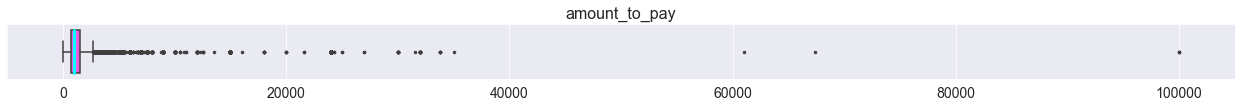

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  3.65it/s]

,count,mean,std,min,5%,25%,50%,75%,95%,max
amount_paid,8143.0,1817.35,972.74,200.0,800.0,1100.0,1500.0,2000.0,3750.0,24000.0


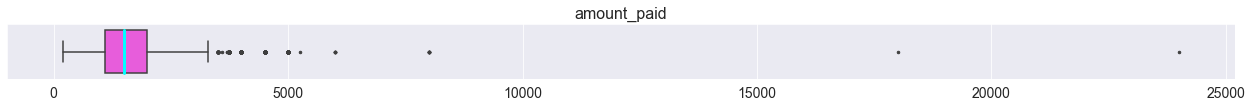

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s]


In [77]:
for i in tqdm(amount_pay_lessons):
    display(pd.DataFrame(lessons[i]).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T)
    plt.figure(figsize=(22,1))
    sns.boxplot(x=lessons[i],
        boxprops={'facecolor': (.9, .0, .8, .6)},flierprops={'marker': '.'},
        medianprops={'color': 'cyan', 'linewidth':3}
    )
    plt.title(i, fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlabel('')
    plt.show()

В 95% случаев стоимость занятий не превышает 2.5к, а не меньше половины в пределах 1к. Не менее 95% оплат находятся в диапазоне до 3750р., 50% на отметке 1.5к, пара оплат от 18к.

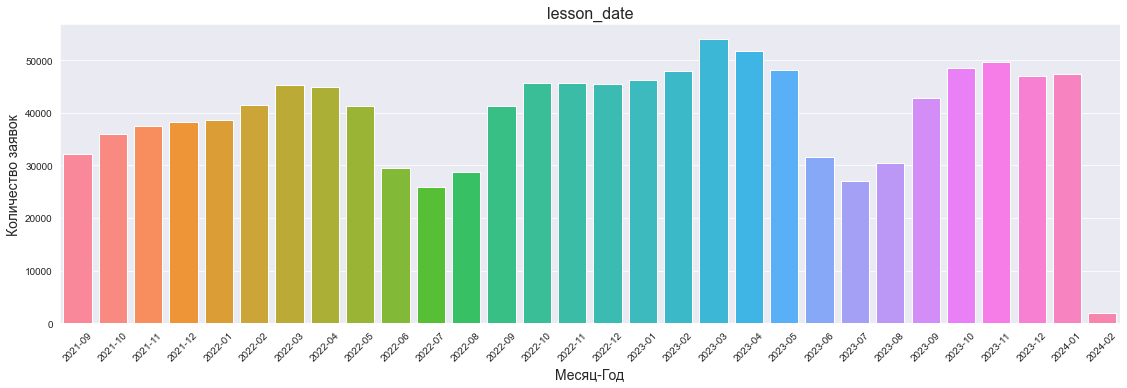

In [78]:
lls = (pd.to_datetime(lessons['lesson_date']).dt.strftime('%Y-%m')
                    .value_counts()).reset_index().sort_values(by='index')    
ax = sns.barplot(x='index',
            y='lesson_date',
            linewidth=1, 
            saturation = 100,
            data=lls)
sns.color_palette()
plt.title('lesson_date', fontsize=16)
plt.xlabel('Месяц-Год', fontsize=14)
plt.ylabel('Количество заявок', fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
ax.figure.set_size_inches(19,5.5)
plt.show()

График в разрезе месяц-год наглядно показывает рост спроса ежегодно с начала учебного года, затем, в начале календарного года  с пиками, приходящимися на март-апрель и последущим снижением в период лених каникул.

## Анализ данных

### Объединение датасетов

In [79]:
# Соединяем информацию по урокам lessons и lesson_course по id курса

full_lessons=pd.merge(lessons, lesson_course, left_on='lesson_course_id', right_on='id', suffixes=('_lessons', '_lesson_course'))

In [80]:
full_lessons.sample(5)

,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid,id_lesson_course,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
929762,3542580,1216117,2023-04-17,20:00:00,20:00:00,NaN,1,NaN,NaN,1216117,1110097.0,38361,2516743.0,4,1800,0,60,2023-06-12 21:12:33.603,1800-01-01 00:00:00.000
687800,2803554,1039040,2022-09-27,21:00:00,21:00:00,NaN,0,600.0,NaN,1039040,990874.0,265525,2193506.0,4,600,1,60,2022-09-14 11:23:13.003,1800-01-01 00:00:00.000
491209,2340879,930065,2022-05-03,20:00:00,20:00:00,NaN,0,900.0,NaN,930065,917287.0,250969,1993825.0,4,900,1,60,2022-03-07 20:06:07.683,1800-01-01 00:00:00.000
476717,3318555,919708,2023-04-14,19:00:00,19:00:00,NaN,1,NaN,NaN,919708,574731.0,163884,1973470.0,4,1000,1,0,2023-08-31 10:43:23.537,2022-07-03 09:16:47.233
462774,3269369,913094,2023-04-25,19:00:00,19:00:00,NaN,0,NaN,NaN,913094,905362.0,202690,NaN,4,0,0,0,2022-02-09 18:19:49.643,1800-01-01 00:00:00.000


In [81]:
# Соединяем teachers и teachers_info по id репетитора

teachers_wo_prices = pd.merge(teachers, teachers_info, left_on='id', right_on='id', suffixes=('_teachers', '_teachers_info'))

In [82]:
teachers_wo_prices.sample(5)

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
820,179094,88.0,1082.558140,86.0,0.104348,7.166667,93100.0,0,2019-09-17 18:11:07.500,2001-09-11,2019-09-01,0,60,1500,1,2022-09-04 21:34:31.457,NaN,0,1,2,1,17
900,125321,210.0,2473.134328,67.0,0.189655,6.090909,165700.0,0,2017-08-22 23:46:09.000,1963-09-29,1985-09-01,0,30,1000,1,2022-09-11 10:11:15.237,NaN,0,1,2,1,65
404,260625,367.0,1445.454545,55.0,0.266667,13.750000,79500.0,0,2022-05-11 20:41:27.217,1995-05-17,2016-09-01,0,60,1490,1,2022-05-14 15:12:32.663,NaN,0,1,2,1,0
741,114012,55.0,14625.000000,8.0,0.030303,8.000000,117000.0,1,2017-01-11 12:33:49.000,1997-06-25,2014-09-01,0,60,4000,1,2022-10-23 15:59:21.307,NaN,0,1,1,1,24
781,296431,33.0,639.130435,23.0,0.150000,7.666667,14700.0,1,2023-06-18 21:27:26.337,2004-10-26,2020-09-01,0,60,400,0,NaT,NaN,0,1,2,0,1


In [83]:
# Присоединяем к репетиторам по их id датасет с расценками

full_teachers = pd.merge(teachers_wo_prices, teacher_prices, left_on='id', right_on='teacher_id', suffixes=('_teachers_wo_prices', '_teacher_prices'))

In [84]:
full_teachers.sample(5)

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,teacher_id,subject_id,price,price_external,price_remote
2512,261459,56.0,2000.000000,4.0,0.166667,2.000000,8000.0,0,2022-05-25 15:17:11.090,1978-01-27,2000-09-01,0,60,1200,1,2022-10-20 17:16:27.853,NaN,0,43,1,1,2,2022-05-25 15:37:59.580,261459.0,10,0,2000,2000
1223,216728,10.0,2500.000000,9.0,0.250000,9.000000,22500.0,0,2020-10-28 13:48:44.833,1972-06-11,1994-09-01,0,60,1500,1,2022-10-12 21:32:06.853,NaN,0,1,2,1,4,2020-10-28 18:08:13.397,216728.0,1,5000,5000,5000
802,147281,501.0,2039.285714,252.0,0.229885,12.600000,513900.0,0,2018-08-27 11:47:03.317,1969-03-26,1989-09-01,0,60,3000,1,2022-10-19 18:02:31.743,NaN,0,2,2,0,7,2018-09-07 20:09:17.540,147281.0,2,3000,0,2500
788,216267,106.0,1567.961165,103.0,0.181818,12.875000,161500.0,1,2020-10-24 15:08:13.720,1989-08-21,2012-09-01,0,60,1500,1,2022-10-24 16:19:12.870,NaN,0,1,2,1,15,2020-10-25 13:45:27.620,216267.0,3,1500,0,1500
1511,169090,55.0,1500.000000,50.0,0.175000,7.142857,75000.0,1,2019-06-17 11:06:53.370,1992-11-20,2013-09-01,0,60,2000,1,2022-10-23 22:57:13.520,NaN,0,1,2,1,1,2022-10-23 23:03:54.200,169090.0,1,2000,0,1500


In [85]:
# Объединяем заявки и нформацию по урокам по id заявок

orders_and_lessons = pd.merge(orders, full_lessons, left_on='id', right_on='order_id', suffixes=('_orders', '_full_lessons'))

In [86]:
orders_and_lessons.sample(5)

,id,order_date,subject_id,purpose,lesson_price_orders,lesson_duration_orders,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id_orders,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay_full_lessons,amount_paid,id_lesson_course,client_id_full_lessons,teacher_id,order_id,lesson_place_full_lessons,lesson_price_full_lessons,is_active,lesson_duration_full_lessons,date_updated,suspend_till_date
255372,2570776,2023-04-15 10:46:33.320,20.0,Разделы: афазия.\nКатегория ученика: Взрослые.\n,5000,60,None,NaN,Количество занятий в неделю: 2-3.\nОпыт репетитора: от 10 лет.\nВозраст репетитора: от 25 лет до 90 лет.\nПол репетитора: Не важно.\n,2023-04-15 10:48:08.847,145938.0,6,None,NaN,0.0,10,2023-04-25,1180902.0,15.0,5,0,0,10,0,4,0,25,90,0,0,23,NaN,1132079,NaN,NaN,0.0,NaT,1,3558514,1254213,2023-04-25,10:00:00,10:00:00,NaN,0,2500.0,NaN,1254213,1132079.0,145938,2570776.0,4,2500,1,60,2023-04-19 10:52:27.410,1800-01-01
703450,2126363,2022-08-06 20:24:43.847,1.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса.\nЦель занятий: Подготовиться к ЕГЭ,2500,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 2. Дни и время по договоренности\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.",2022-08-08 11:33:49.413,133249.0,14,Тестовая группа : SplitTestB,NaN,1500.0,10,2022-09-11,960347.0,12.0,4,1000,3,0,0,4,0,0,0,0,0,16,NaN,939471,21.0,NaN,8500.0,NaT,1,2640147,1003186,2022-08-18,14:30:00,14:30:00,NaN,0,2500.0,NaN,1003186,939471.0,133249,2126363.0,4,1000,0,60,2022-09-11 11:54:33.420,2022-09-09
599090,2003543,2022-03-16 16:28:03.010,23.0,"Разделы: язык-посредник: английский.\nКатегория ученика: взрослый.\nУровень знаний: продвинутый.\nЦель занятий: Хочу найти себе репетитора русского языка как иностранного, чтобы улучшить свой разговорный язык. Сейчас нахожусь в Китае, оплата переводом через сбербанк. Опыт работы с иностранцами н...",1200,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype). Ученик в Китае\nПредполагаемое число занятий в неделю: 2. По средам и пятницам. По договоренности\nОпыт репетитора: от 2 лет.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.",2022-03-16 16:31:52.983,1981.0,16,None,NaN,0.0,10,NaT,879714.0,15.0,4,800,3,2,0,4,4,0,0,0,0,14,2001388.0,917118,17.0,NaN,3480.0,NaT,1,2369889,935066,2022-03-23,13:38:00,13:38:00,NaN,0,1200.0,NaN,935066,917118.0,1981,2003543.0,4,1200,0,60,2022-03-21 10:39:06.653,1800-01-01
697562,2120223,2022-07-31 16:57:29.493,21.0,Разделы: фольклор.\nКатегория ученика: студент.\nЦель занятий: подготовка к поступлению в аспирантуру 2023 г.,1000,60,None,170.0,"Район: м. Марьино.\nМесто проведения занятий: у ученика (Луговой проезд, д. 12), у преподавателя (), дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, по договоренности.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не им...",2022-07-31 18:43:49.183,64501.0,6,Тестовая группа : SplitTestA\n?Статус дозаполнения : начато заполнение клиентом?\n?Статус дозаполнения : начато заполнение клиентом?\n?Статус дозаполнения : Заполнена клиентом?,NaN,2700.0,10,2022-08-12,NaN,14.0,3,0,3,0,0,7,0,0,0,0,0,16,NaN,965145,NaN,NaN,2700.0,2022-08-18 20:49:34.707,1,2643808,999026,2023-07-14,18:30:00,18:30:00,NaN,0,1000.

In [87]:
# Собираем полный датасет репетиторы и заявки-уроки по id репетитора

full_data = pd.merge(orders_and_lessons, full_teachers, left_on='working_teacher_id', right_on='id', suffixes=('_orders_and_lessons', '_full_teachers'))

In [88]:
full_data.sample(5)

,id_orders_and_lessons,order_date,subject_id_orders_and_lessons,purpose,lesson_price_orders,lesson_duration_orders,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id_orders,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay_full_lessons,amount_paid,id_lesson_course,client_id_full_lessons,teacher_id_orders_and_lessons,order_id,lesson_place_full_lessons,lesson_price_full_lessons,is_active,lesson_duration_full_lessons,date_updated,suspend_till_date,id_full_teachers,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,teacher_id_full_teachers,subject_id_full_teachers,price,price_external,price_remote
275702,2356371,2022-12-04 14:54:50.337,8.0,Разделы: школьный курс.\nДополнения: подготовка к олимпиадам.\nКатегория ученика: школьник 4 класса.\nЦель занятий: подготовка к поступлению в математический класс в 5-й класс (контрольная будет в конце января). Участие в олимпиадах. \nРазвить интерес к предмету.,2000,60,None,459.0,"Район: г. Зеленоград.\nМесто проведения занятий: у преподавателя (3 микрорайон и прилегающие), дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2. Вторник, Четверг - после 14 часов. Возможно: Понедельник, Среда, Пятница после 17 часов, выходные - время по договорённости...",2022-12-04 16:16:51.457,140430.0,6,None,NaN,0.0,10,2022-12-05,256616.0,5.0,3,500,1,0,0,6,0,23,60,0,0,14,2356132.0,1045341,NaN,NaN,0.0,NaT,1,3144692,1121989,2023-02-13,18:30:00,18:30:00,NaN,0,NaN,NaN,1121989,1045341.0,140430,2356371.0,6,1700,1,0,2023-06-22 10:44:28.960,1800-01-01,140430,441.0,1963.594470,434.0,0.316667,22.842105,852200.0,0,2018-03-15 22:03:23.000,1998-01-17,2017-09-01,0,60,1500,1,2022-10-21 10:51:29.873,NaN,0,1,1,1,20,2018-03-21 12:05:24.897,140430.0,8,0,4000,3000
241198,1829783,2021-10-20 15:04:59.873,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 7 класса.\nЦель занятий: помощь по школьной программе.,550,60,None,1086.0,"Район: г. Междуреченск.\nМесто проведения занятий: у ученика (проспект Строителей), у преподавателя , дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, понедельник, среда с 15 по местному времени. - 4 часа МСК\nОпыт репетитора: от 5 лет.\nВозраст репетитора: не имеет з...",2021-10-20 18:09:15.470,133301.0,6,Тестовая группа : SplitTestA,NaN,1800.0,10,2021-10-23,NaN,8.0,3,300,3,5,0,7,0,0,0,0,0,16,NaN,861360,NaN,NaN,1650.0,2021-10-28 14:50:50.330,1,3656361,841739,2023-07-12,15:10:00,15:10:00,NaN,0,600.0,NaN,841739,861360.0,133301,1829783.0,7,600,1,60,2021-10-21 20:51:30.677,1800-01-01,133301,397.0,668.287938,257.0,0.268817,10.280000,171750.0,0,2017-11-03 03:01:23.000,1997-02-05,2015-09-01,0,60,500,1,2022-10-04 10:43:14.477,NaN,0,1,1,1,79,2017-11-08 16:40:00.873,133301.0,8,600,600,600
270423,2359288,2022-12-06 09:38:04.307,8.0,Разделы: школьный курс.\nДополнения: подготовка к олимпиадам.\nКатегория ученика: школьник 4 класса.\nЦель занятий: углубленное изучение.,1500,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 2. Будни время обсуждается.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.",2022-12-06 12:28:37.507,189372.0,6,

In [89]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469741 entries, 0 to 469740
Data columns (total 85 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   id_orders_and_lessons          469741 non-null  int32         
 1   order_date                     469741 non-null  datetime64[ns]
 2   subject_id_orders_and_lessons  469741 non-null  float32       
 3   purpose                        469492 non-null  object        
 4   lesson_price_orders            469741 non-null  int32         
 5   lesson_duration_orders         469741 non-null  int32         
 6   lesson_place_orders            0 non-null       object        
 7   home_metro_id                  115454 non-null  float32       
 8   add_info                       469417 non-null  object        
 9   start_date                     469714 non-null  datetime64[ns]
 10  working_teacher_id             469741 non-null  float32       
 11  

In [90]:
full_data_copy = full_data.copy()

In [91]:
full_data_copy[full_data_copy['amount_paid'].isna()]['amount_paid'].count()

0

In [92]:
full_data_copy['amount_paid'].fillna(0, inplace=True)

### Генерация признаков

In [93]:
# Создаем бинарный признак, позволяющий определить факт оплаты

def apply_status(row):
    if row['amount_paid'] == 0 & (row['status_id'] == 6 or row['status_id'] == 13 \
    or row['additional_status_id']== 6 or row['additional_status_id'] == 13):
        return 1
    else:
        return 0
full_data_copy['status_id_is_6/13'] = full_data_copy.apply(apply_status, axis=1)

In [94]:
def apply_price_area(row):
    if (row['area_id'] == 1 and row['mean_lesson_price'] <= 700) \
    or (row['area_id'] != 1 and row['mean_lesson_price'] <= 500):
        return 1
    else:
        return 0
full_data_copy['price_area'] = full_data_copy.apply(apply_price_area, axis=1)

In [95]:
def apply_pupil_money(row):
    if (row['lessons_per_pupil'] <= 2 and row['money_recieved'] < 5000) \
    or (row['lessons_per_pupil'] > 2):
        return 0
    else:
        return 1
full_data_copy['pupil_money_recieved'] = full_data_copy.apply(apply_pupil_money, axis=1)

### Матрица корреляции $\phi_K$

In [96]:
full_data_copy.dropna(how='all', inplace=True, axis=1)

In [97]:
datetime_features =  full_data_copy.select_dtypes(include='datetime64[ns]').columns.to_list()
datetime_features

['order_date',
 'start_date',
 'first_lesson_date',
 'payment_date',
 'date_updated',
 'suspend_till_date',
 'reg_date',
 'birth_date',
 'teaching_start_date',
 'last_visited',
 'date_update']

In [98]:
full_data_copy.drop(['purpose', 'add_info', 'time_from', 'time_to', 'home_task', 'id_orders_and_lessons', \
                     'comments', 'creator_id', 'teacher_experience_from', 'teacher_experience_to', \
                     'client_id_orders', 'id_lessons', 'id_lesson_course', 'client_id_full_lessons', 'is_email_confirmed', \
                     'is_cell_phone_confirmed', 'orders_allowed', 'pupil_knowledgelvl', 'no_teachers_available', 'source_id',\
                     'subject_id_full_teachers', 'teacher_id_full_teachers', 'id_full_teachers', 'is_display_to_teachers', \
                     'teacher_id_orders_and_lessons'], inplace=True, axis=1)

In [99]:
phik_overview = full_data_copy.drop(datetime_features, axis=1).phik_matrix()
phik_overview.columns

interval columns not set, guessing: ['subject_id_orders_and_lessons', 'lesson_price_orders', 'lesson_duration_orders', 'home_metro_id', 'working_teacher_id', 'status_id', 'amount_to_pay_orders', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'lesson_place_new', 'teacher_age_from', 'teacher_age_to', 'chosen_teachers_only', 'original_order_id', 'additional_status_id', 'max_metro_distance', 'estimated_fee', 'lesson_course_id', 'is_regular', 'amount_to_pay_full_lessons', 'amount_paid', 'order_id', 'lesson_place_full_lessons', 'lesson_price_full_lessons', 'is_active', 'lesson_duration_full_lessons', 'lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved', 'blocked', 'lesson_duration', 'lesson_cost', 'is_display', 'is_pupils_needed', 'area_id', 'sex', 'review_num', 'price', 'price_external', 'price_remote', 'status_id_is_6/13', 'price_area', 'pupil_money_recieved']


Index(['subject_id_orders_and_lessons', 'lesson_price_orders',
       'lesson_duration_orders', 'home_metro_id', 'working_teacher_id',
       'status_id', 'amount_to_pay_orders', 'planned_lesson_number',
       'pupil_category_new_id', 'lessons_per_week', 'minimal_price',
       'teacher_sex', 'lesson_place_new', 'teacher_age_from', 'teacher_age_to',
       'chosen_teachers_only', 'original_order_id', 'additional_status_id',
       'max_metro_distance', 'estimated_fee', 'lesson_course_id',
       'lesson_date', 'is_regular', 'amount_to_pay_full_lessons',
       'amount_paid', 'order_id', 'lesson_place_full_lessons',
       'lesson_price_full_lessons', 'is_active',
       'lesson_duration_full_lessons', 'lessons_delivered',
       'mean_lesson_price', 'lessons_given', 'lessons_started_fraction',
       'lessons_per_pupil', 'money_recieved', 'blocked', 'lesson_duration',
       'lesson_cost', 'is_display', 'is_pupils_needed', 'area_id', 'sex',
       'review_num', 'price', 'price_externa

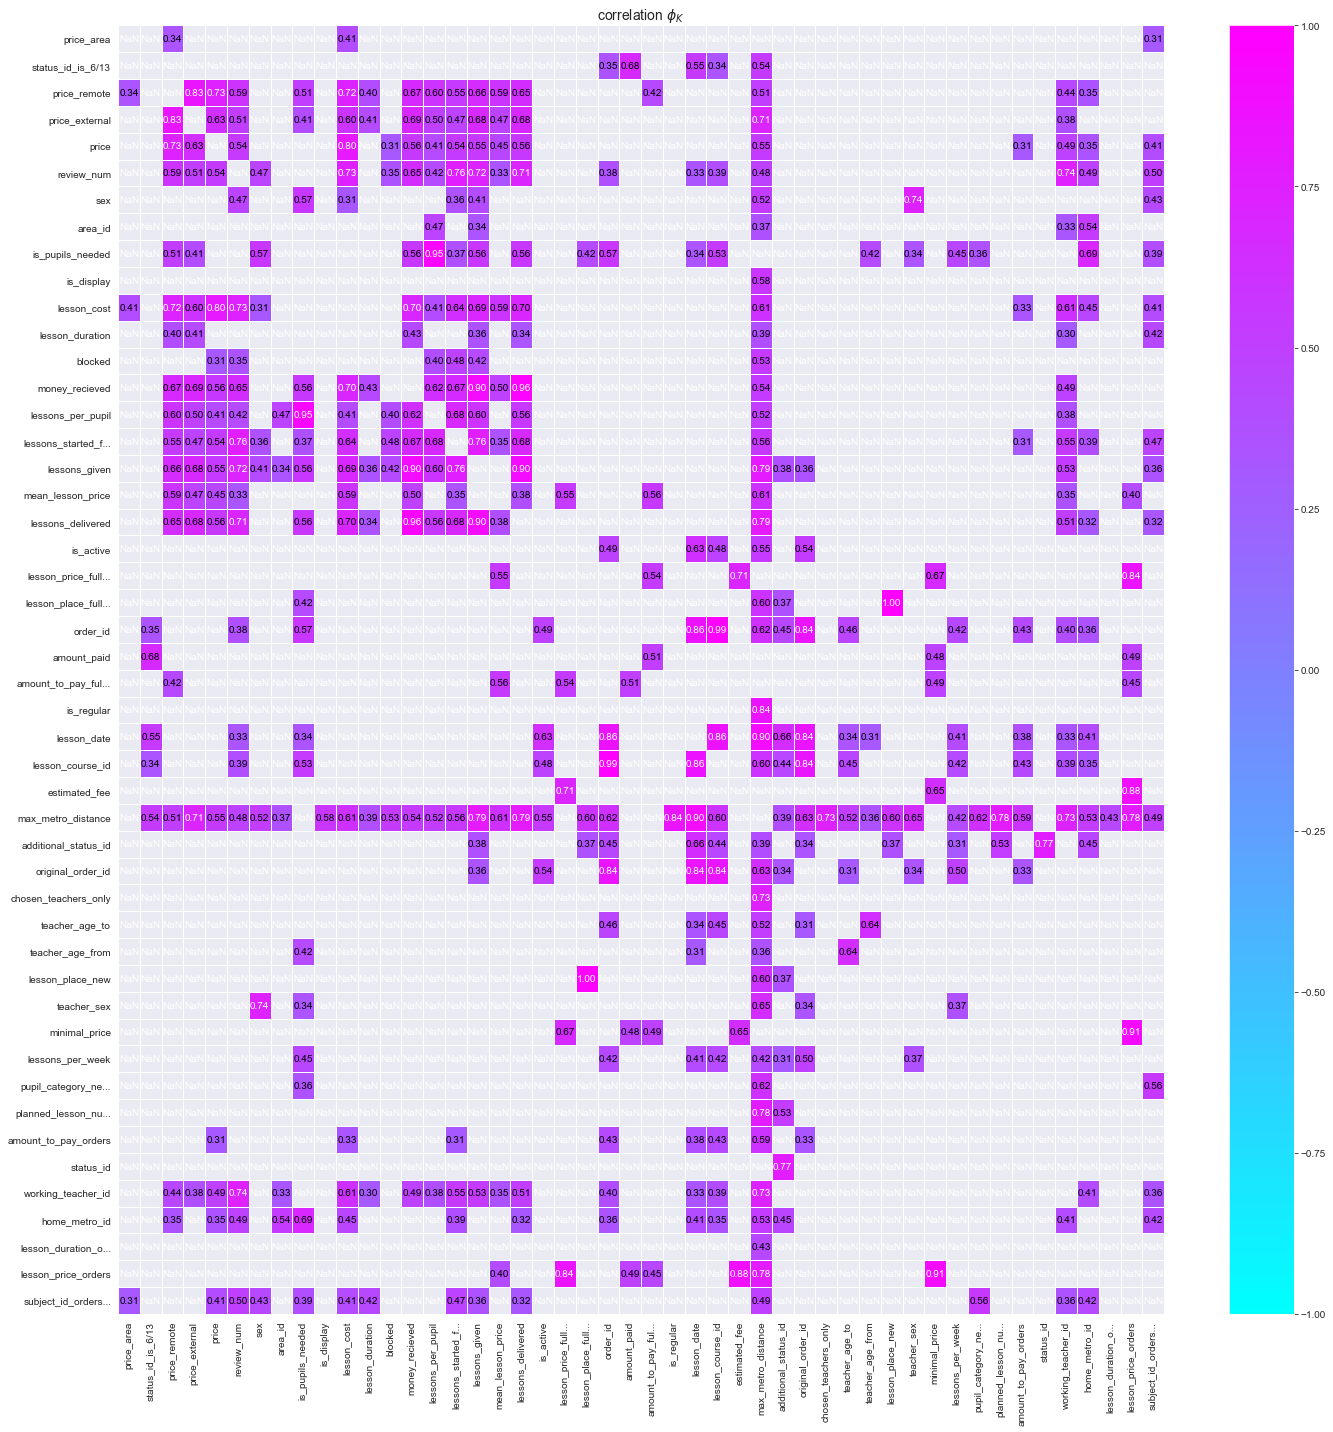

In [100]:
#phik_overview = full_data_copy.drop(datetime_features, axis=1).phik_matrix()
filter_data = phik_overview[(phik_overview >= .3) & (phik_overview != 1)].dropna(how='all', axis=1)
filter_data_upd = filter_data.dropna(how='all', axis=0)
plot_correlation_matrix(filter_data_upd.values, x_labels=filter_data_upd.columns, y_labels=filter_data_upd.index,
                        title=r'correlation $\phi_K$', figsize=(20,20), fontsize_factor=1, color_map='cool')

#annot=False,

In [101]:
pivot_data = full_data_copy.groupby('working_teacher_id').agg(
    {'order_id': 'count',  \
     'mean_lesson_price': 'mean',  'status_id_is_6/13': 'mean', \
     'money_recieved': 'first', 'lessons_started_fraction': 'first', \
     'pupil_money_recieved': 'first', 'blocked': 'first', \
     'review_num': 'count', 'price_area': 'first'
    }).reset_index()

In [102]:
pivot_data['raiting'] = pivot_data['order_id'] / pivot_data['money_recieved']

In [103]:
# pivot_data = full_data_copy.groupby('working_teacher_id').agg(
#     {'lessons_given': 'first', 'price': 'median',   \
#      'lessons_started_fraction': 'first', 'blocked': 'first', \
#      'review_num': 'mean', 'lessons_per_pupil': 'first'
#     }).reset_index()

In [104]:
pivot_data.sample(10)

,working_teacher_id,order_id,mean_lesson_price,status_id_is_6/13,money_recieved,lessons_started_fraction,pupil_money_recieved,blocked,review_num,price_area,raiting
391,128999.0,38,1169.230769,1.0,15200.0,0.088235,0,0,38,0,0.002500
1102,260728.0,22,1500.000000,1.0,3000.0,0.111111,0,0,22,0,0.007333
1500,307311.0,56,750.000000,1.0,21000.0,0.111111,0,0,56,0,0.002667
146,60069.0,54,2714.285714,1.0,19000.0,0.064516,0,0,54,0,0.002842
591,165487.0,240,1695.739910,1.0,378150.0,0.163462,0,0,240,0,0.000635
1198,274409.0,12,2671.428571,1.0,18700.0,0.266667,1,0,12,0,0.000642
1475,304409.0,24,1454.166667,1.0,17450.0,0.250000,0,0,24,0,0.001375
943,232544.0,70,3265.625000,1.0,52250.0,0.424242,1,1,70,0,0.001340
1407,294218.0,206,885.537190,1.0,107150.0,0.236842,0,1,206,0,0.001923
1268,282255.0,2,800.000000,1.0,3200.0,0.090909,0,0,2,0,0.000625


In [105]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   working_teacher_id        1524 non-null   float64
 1   order_id                  1524 non-null   int64  
 2   mean_lesson_price         1524 non-null   float64
 3   status_id_is_6/13         1524 non-null   float64
 4   money_recieved            1524 non-null   float64
 5   lessons_started_fraction  1524 non-null   float64
 6   pupil_money_recieved      1524 non-null   int64  
 7   blocked                   1524 non-null   int64  
 8   review_num                1524 non-null   int64  
 9   price_area                1524 non-null   int64  
 10  raiting                   1524 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 131.1 KB


## Модель

In [106]:
features = pivot_data.drop('blocked', axis=1)
target = pivot_data['blocked']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, shuffle = True, random_state=RANDOM_STATE)

In [107]:
# Выведем размеры обучающей и тестовой выборок

print(f'Размер обучающей выборки: признаки - {features_train.shape}, целевая переменная - {target_train.shape[0]}')
print(f'Размер тестовой выборки: признаки - {features_test.shape}, целевая переменная - {target_test.shape[0]}')

Размер обучающей выборки: признаки - (1143, 10), целевая переменная - 1143
Размер тестовой выборки: признаки - (381, 10), целевая переменная - 381


### Случайный лес

In [108]:
# Используем пайплайн с целью избежания утечки данных и 
# GridSearchCV для подбора гиперпараметров при помощи кросс-валидации

pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))],
                verbose = True)

param_random_rf = {
    'rfc__bootstrap': [True, False],
     'rfc__n_estimators': range(10, 101, 10),
     'rfc__max_depth': range(2, 15),
     'rfc__min_samples_split': (2, 3, 4),
     'rfc__min_samples_leaf': (1, 2, 3, 4)
}

gs_rf = GridSearchCV(
    pipe, 
    param_grid=param_random_rf, 
    scoring='f1',
    cv=5,
    n_jobs=-1
)

In [109]:
%%time
gs_rf.fit(features_train, target_train)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing rfc, total=   0.1s
{'rfc__bootstrap': True, 'rfc__max_depth': 5, 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 20}
0.5895540538312704
CPU times: total: 26.9 s
Wall time: 14min 47s


In [110]:
%%time
predicted_test = gs_rf.predict(features_test)

CPU times: total: 15.6 ms
Wall time: 7.94 ms


In [111]:
result_test_f1 = f1_score(target_test, predicted_test)
print(f'F1 модели RandomForestClassifier: {result_test_f1:.4f}')

F1 модели RandomForestClassifier: 0.6238


#### Матрица ошибок

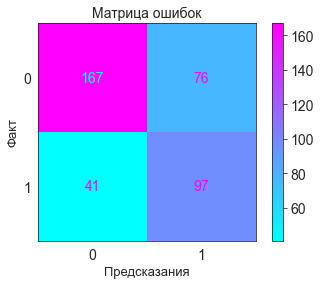

In [121]:
sns.set_style('white')
plt.rcParams.update({'font.size': 14})
ConfusionMatrixDisplay.from_estimator(gs_rf, features_test, target_test, cmap=plt.cm.cool)
plt.title('Матрица ошибок', fontsize=14)
plt.xlabel('Предсказания', fontsize=13)
plt.ylabel('Факт', fontsize=13)
plt.show()

#### Важность признаков

In [113]:
feature_names = features.columns
start_time = time.time()
result = permutation_importance(
    gs_rf, features_test, target_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f'Затраченное время на вычисление важности: {elapsed_time:.3f} секунд')

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Затраченное время на вычисление важности: 0.395 секунд


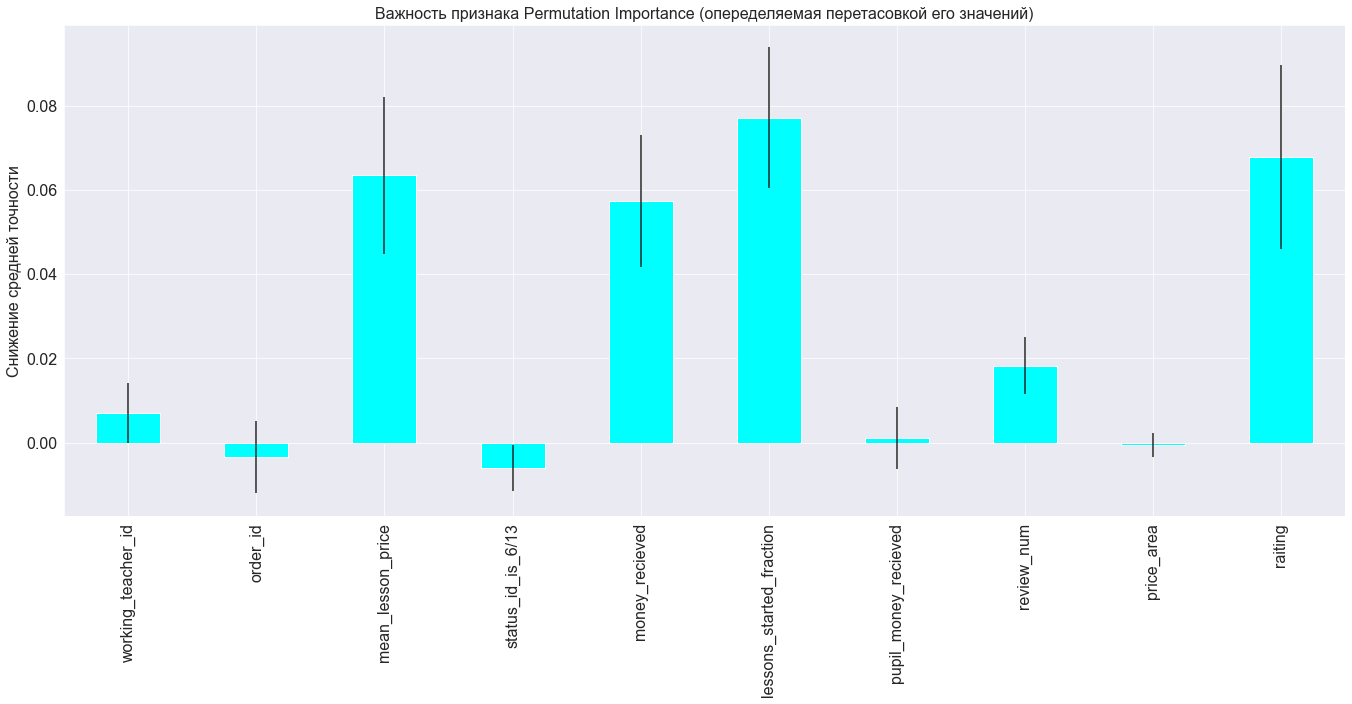

In [114]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(19,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, fontsize=16, cmap=plt.cm.cool)
ax.set_title("Важность признака Permutation Importance (опеределяемая перетасовкой его значений)", fontsize=16)
ax.set_ylabel("Снижение средней точности", fontsize=16)
fig.tight_layout()
plt.show()

### Случайная модель

Создадим константную модель: любому объекту она прогнозирует класс «1»

In [115]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
print(f'F1 константной модели: {f1_score(target_test, dummy_model.predict(features_test)):.4f}')

F1 константной модели: 0.5318


## Вывод

Для решения задачи выявления недобросовестных репетиторов сервиса Repetit.ru были предоставлены данные о заявках, тарифах, уроках, репетиторах.  
В ходе анализа и предобработки данных было выполнено объединение 6-ти датафреймов, преобразован тип данных, обработаны пустые строки в колонке amount_paid, удалены аномалии.
Сгенерированы следующие признаки:
1. Сопоставляющий статус заявки, как оплаченный и фактически оставшийся неоплаченным.
2. Пороги стоимости занятий для Москвы от 700 руб., для регионов - от 500
3. Соотношение кол-ва уроков на ученика не более 2-х и при этом общая сумма оплаты менее 5к (что выглядит объяснимым только для новых репетиров)
4. Соотношение кол-ва заявок на заработанную сумму денег.

Построена матрица корреляции $\phi_K$, на основании коэффициентов которой был определен отдельный набор признаков с последующим обучением.
В качестве модели обучения был выбран слусайный лес, т.к. устойчив к переобучению на столь небольших данных.  
Для модели, требующей масштабирования численных признаков было произведено скалирование с применением пайплайна, с целью избежания утечки данных.  
Подбор гиперпараметров был произведён с помощью GridSearchCV() и на кросс-валидации определена метрика F1.  
На тестовых данных метрика F1 модели RandomForestClassifier с гиперпараметрами {'rfc__bootstrap': True, 'rfc__max_depth': 5, 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 20} составила __0.6238__.

Анализ важности признаков показал, что фича __Процент начала занятий__ имеет наибольший вес, так же в большой степени модель опирается на признаки __Средняя стоимость уроков__ и __Получено денег__.  
Из сгенерированных признаков эффективен только __Рейтинг__. 

Было проведено сравнение с константной моделью, её результат составил 0.5318 - таким образом, наша модель прошла проверку на адекватность.  
Однако, говорить о высоком качестве модели было бы необъективно. Поскольку, как правило, бизнес в первую очередь интересует предсказание положительного класса стоит ориентироваться в большей степени на метрику Recall, но в нашем случае её результат был бы ещё скромнее - модель пропускает ~30% положительных ответов и примерно такую же долю отрицательных ответов предсказывает ошибочно.  
Также было проведено обучение на признаках, которые согласно матрице $\phi_K$ были определены, как наиболее коррелируемые (см.результаты на скриншотах). На обучении модель показала значительно более уверенный результат, чем наша, но на тесте проиграла.
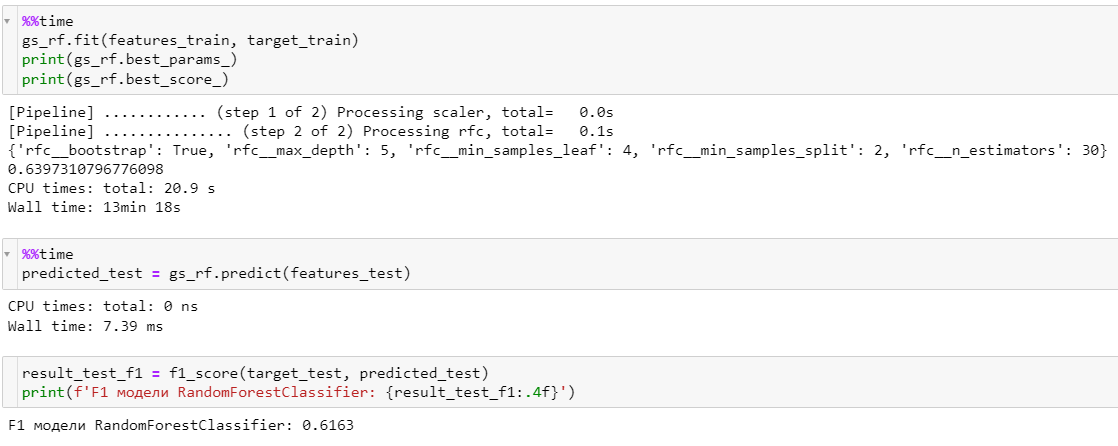
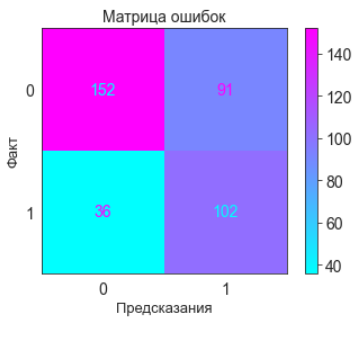
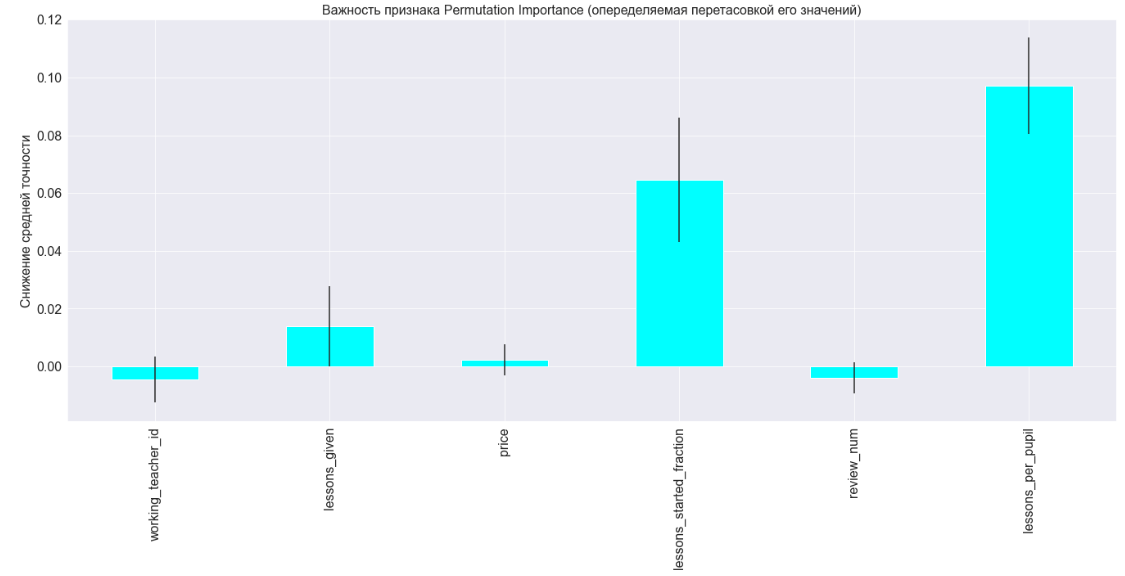
